# Environment

```sh
pwd; date
# /Users/cchiang/research/chiang/projects/covid-19
# Mon Apr 27 05:07:38 EDT 2020

```

## Libraries

In [2]:
# Load packages
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggthemes))
suppressPackageStartupMessages(library(reshape2))
library(tidyverse)
library(deSolve)
library(viridis)

# library(tidyverse)
# library(lubridate)
# library(rvest)
# library(stringdist)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ purrr   0.3.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()

Loading required package: viridisLite



## Options

In [3]:
options(repr.plot.width=12, repr.plot.height=8)

# Data

Data sourced from Johns Hopkins repository
https://github.com/CSSEGISandData/COVID-19

[Time series (global)](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

```sh

pwd; date
# /Users/cchiang/research/chiang/projects/covid-19
# Tue Apr 28 07:26:46 EDT 2020

curl -s https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv \
    | gzip -c > data/jhu/time_series_covid19_deaths_global.csv.gz

curl -s https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv \
    | gzip -c > data/jhu/time_series_covid19_confirmed_global.csv.gz

```

In [719]:
# clean up data
jhu.death <- read_csv('data/jhu/time_series_covid19_deaths_global.csv.gz')
gdeath <- melt(select(jhu.death,
                      'subregion'="Province/State",
                      'region'='Country/Region',
                      matches('[0-9]*/[0-9]*/[0-9]*')),
               id=c('subregion', 'region'),
               variable.name='date', value.name='death')
gdeath$region <- factor(gdeath$region)
gdeath$date <- as.Date(gdeath$date, format='%m/%d/%y')

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



Warning message:
“Ignoring unknown parameters: shape”


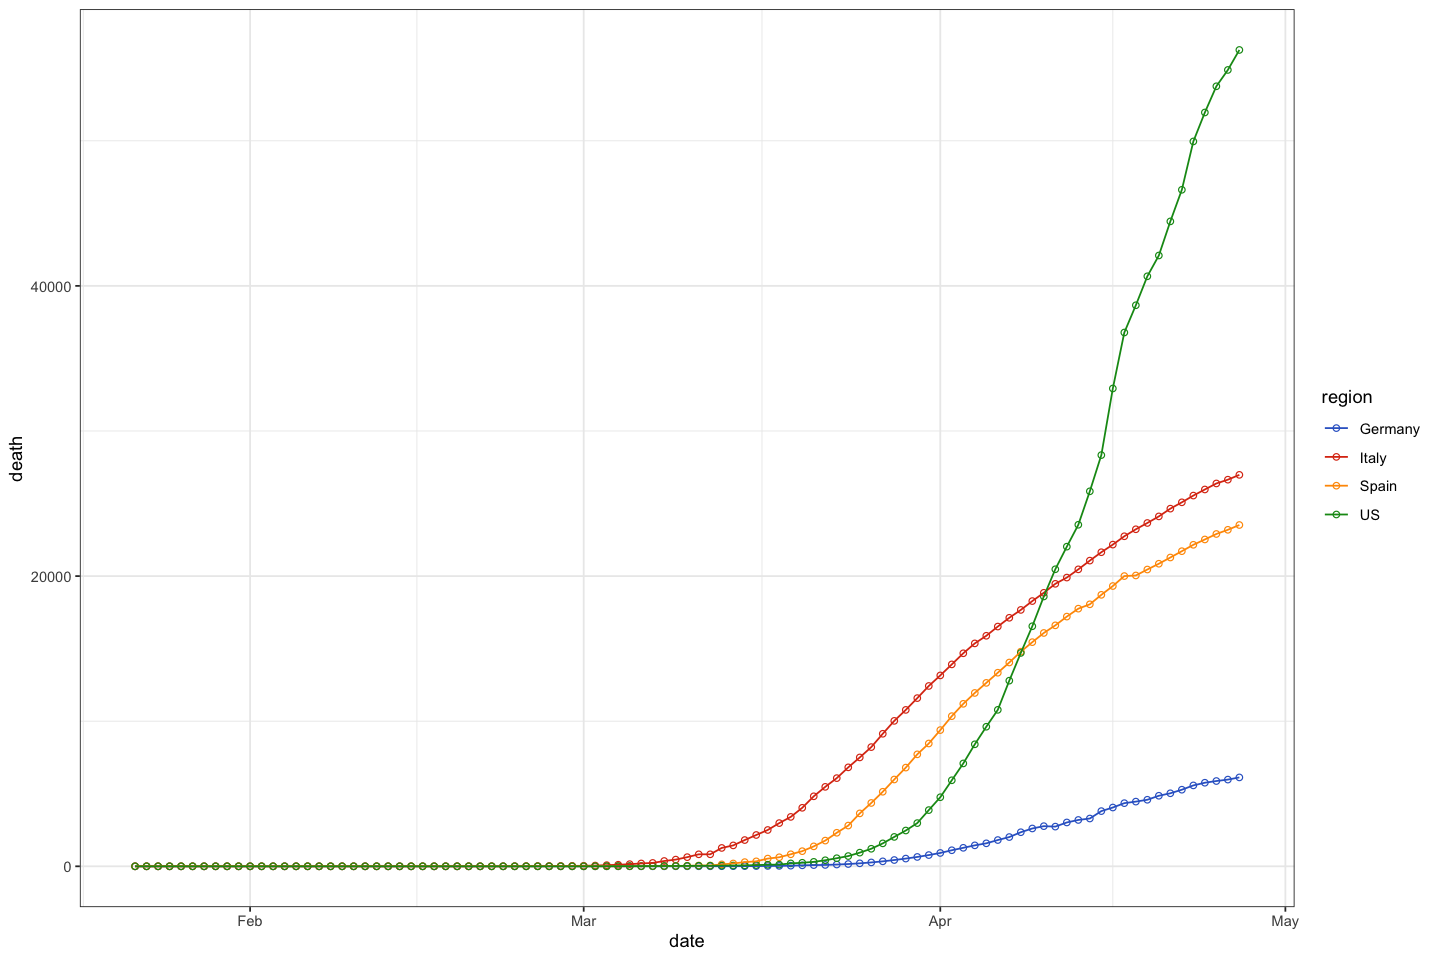

In [720]:
# plot trends in different countries

p <- ggplot(gdeath[gdeath$region %in% c('Italy', 'US', 'Germany', 'Spain'), ], aes(date, death, col=region))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_point(shape=21)
p <- p + geom_line(shape=21)
# p <- p + scale_y_continuous(trans='log10')
p

# SIR Model in Italy

Case reporting for COVID-19 infection prevalence is unreliable due to widespread testing shortages. Reported deaths are more reliable (although still likely to be undercounts) since available testing has been preferentially applied to critically ill patients.

To estimate epidemic trajectory from death reports alone, we'll use a SIR model (susceptible, infected, recovered) with additional category D = deceased.

$$\begin{align}
\frac{dS(t)}{dt} &= -\beta I(t) S(t) \\[10pt]
\frac{dI(t)}{dt} &= \beta S(t) I(t) - (\gamma + \mu) I(t) \\[10pt]
\frac{dR(t)}{dt} &= \gamma I(t) \\[10pt]
\frac{dD(t)}{dt} &= \mu I(t)
\end{align}$$

We'll look at Italy data first, since it offers several advantages

- Affected early, mature trajectory of deaths
- First severely affected Western country, data fairly reliable
- Aggressive testing

## Fit 1: Random Guesses

##### Model

In [721]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [722]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [723]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [724]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

# time zero of virus introduction
t0 <- as.Date('2020-01-23')

##### Observed

In [725]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

In [726]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta, gamma, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


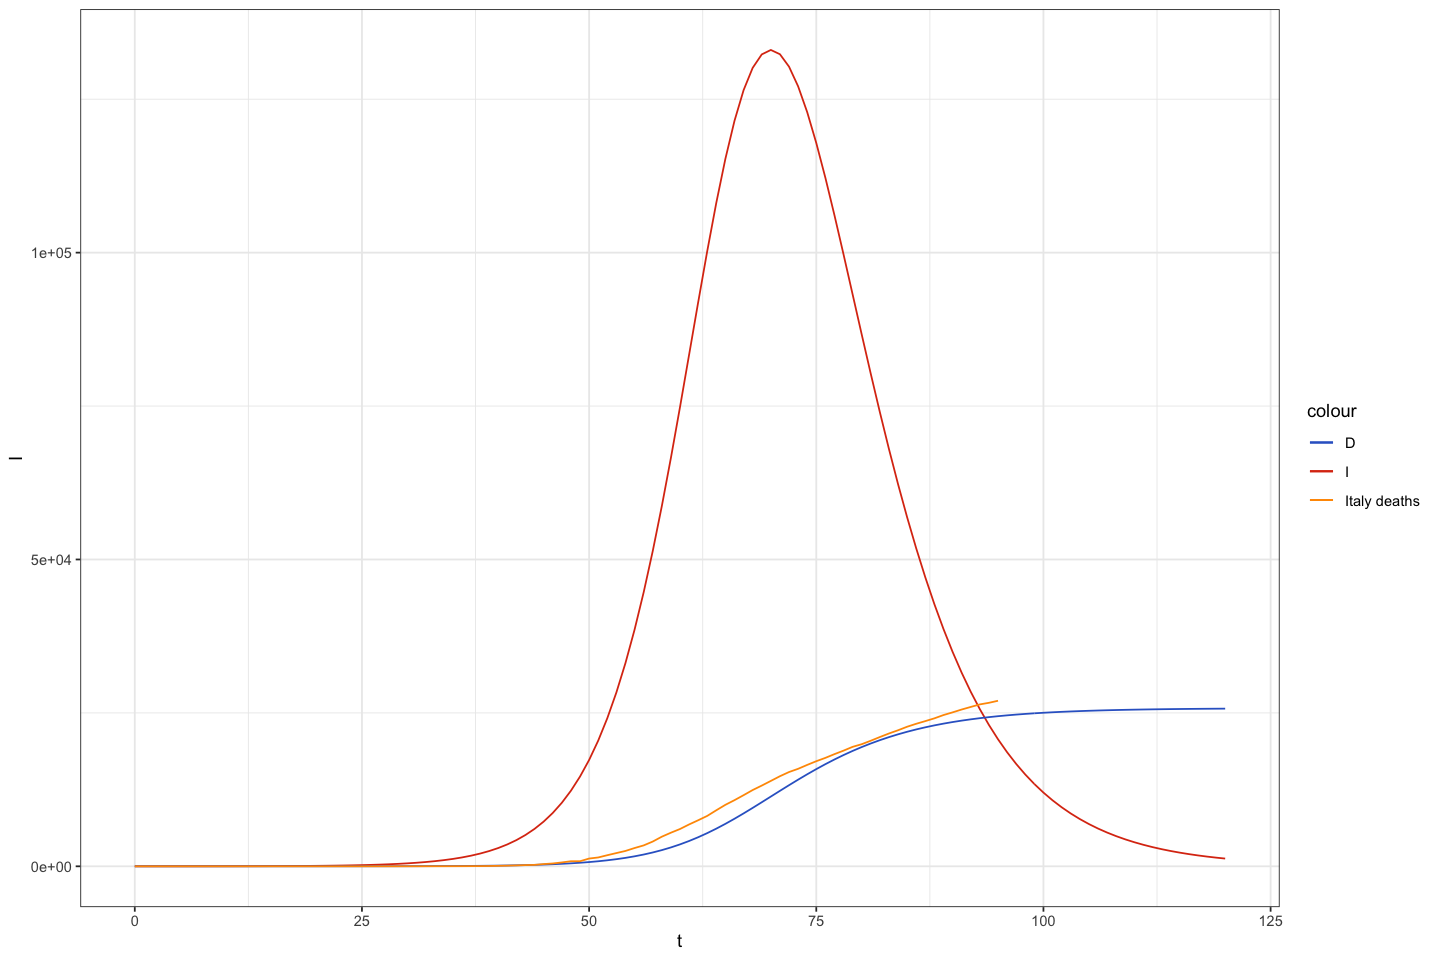

In [727]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p

## Fit 2: Normal (beta optimization)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$, fixed $\mu$ and $\gamma$

##### Model

In [728]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [729]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [730]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [731]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [732]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [733]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [734]:
# parameter iterative function
f1 <- function (beta) {
    params <- c(beta=beta, gamma=gamma, mu=mu, sigma=sigma)
    loglik.normal(params)
}

##### Optimization

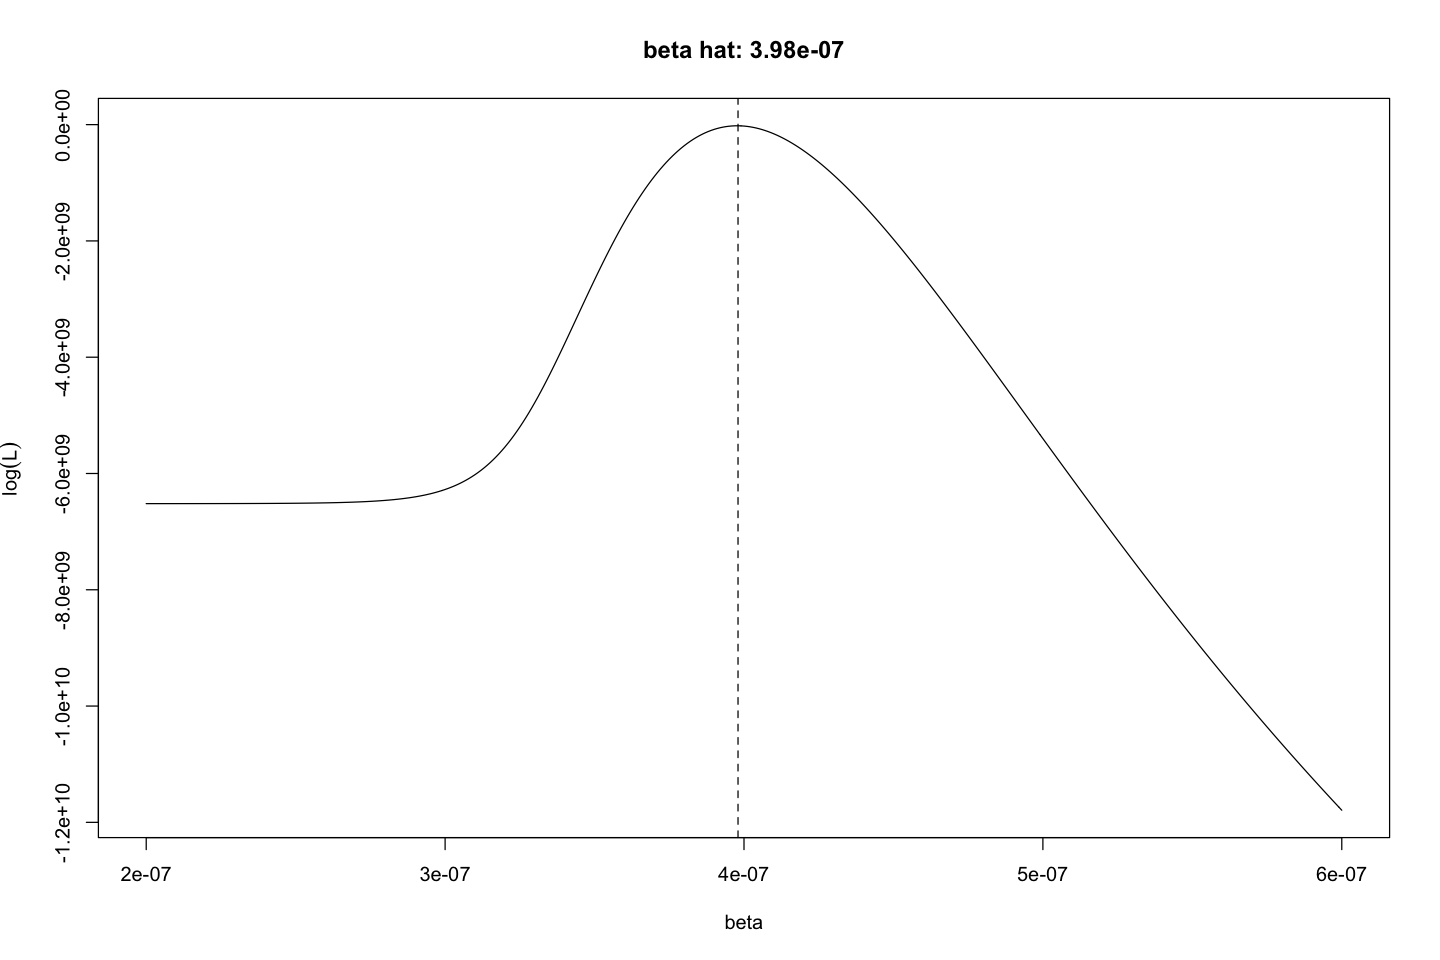

In [735]:
# plot log-likelihood as function of beta
beta <- seq(from=2e-7,to=6e-7,by=1e-9)
ll <- sapply(beta,f1)

beta.hat <- beta[which.max(ll)]
plot(beta, ll, type='l',ylab=expression(log(L)), main=paste0('beta hat: ', beta.hat))
abline(v=beta.hat,lty=2)

##### Trajectory with optimized beta

In [736]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta.hat, gamma, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


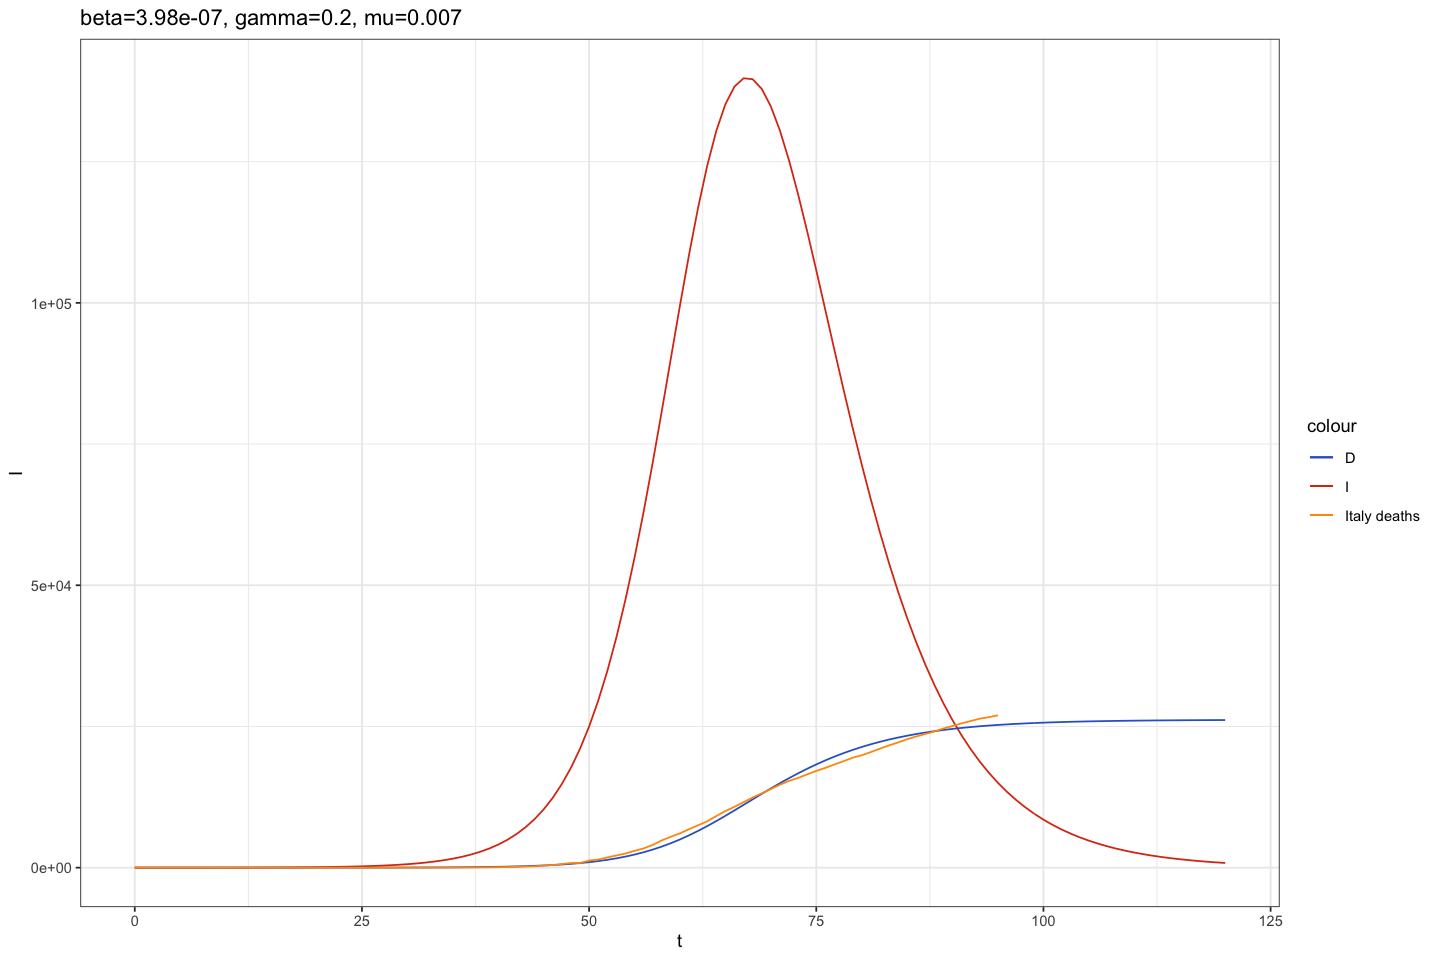

In [737]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('beta=', beta.hat, ', gamma=', gamma, ', mu=', mu))
p

## Fit 3: Normal (beta, gamma optimization)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$ and $\gamma$ simultaneously, fixed $\mu$

##### Model

In [738]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [739]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [740]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [741]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [742]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [743]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [744]:
# parameter iterative function
f2 <- function (log.beta, log.gamma) {
    params <- c(beta=exp(log.beta), gamma=exp(log.gamma), mu=mu, sigma=sigma)
    loglik.normal(params)
}

##### Optimization

In [745]:
grid <- expand.grid(log.beta=seq(from=-14.8,to=-14.65,length=50),
                    log.gamma=seq(from=-1.7,to=-1.5,length=50)
                   )
grid$ll <- unlist(do.call(Map, c(f = f2, grid)))

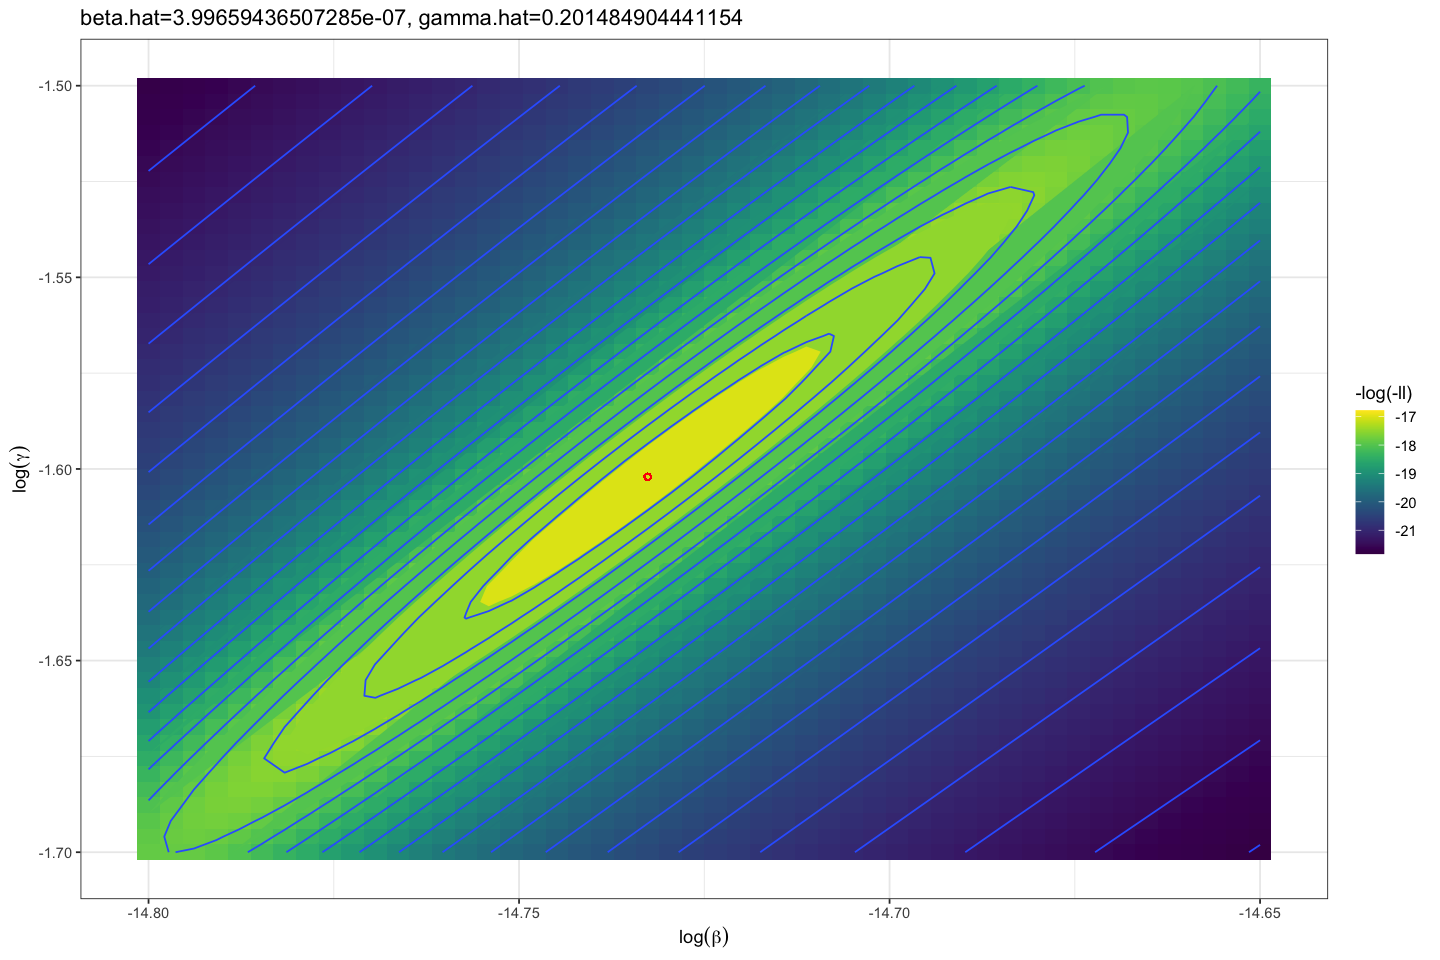

In [746]:
# Contour plot of beta and gamma

opt <- grid[which.max(grid$ll),]
beta.hat <- exp(opt$log.beta)
gamma.hat <- exp(opt$log.gamma)

p <- ggplot(grid, aes(x = log.beta, y = log.gamma, z = -log(-ll)))
p <- p + theme_bw() + scale_fill_viridis()
p <- p + geom_tile(aes(fill = -log(-ll)))
p <- p + stat_contour(geom = 'polygon', aes(fill = ..level..))
p <- p + stat_contour(bins = 20)
p <- p + xlab(expression(log(beta))) + ylab(expression(log(gamma)))
p <- p + ggtitle(paste0('beta.hat=', beta.hat, ', gamma.hat=', gamma.hat))
p <- p + geom_point(aes(x=log(beta.hat), y=log(gamma.hat)), col='red', shape=21)
p

##### Trajectory with optimized beta

In [747]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=c(beta.hat, gamma.hat, mu),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


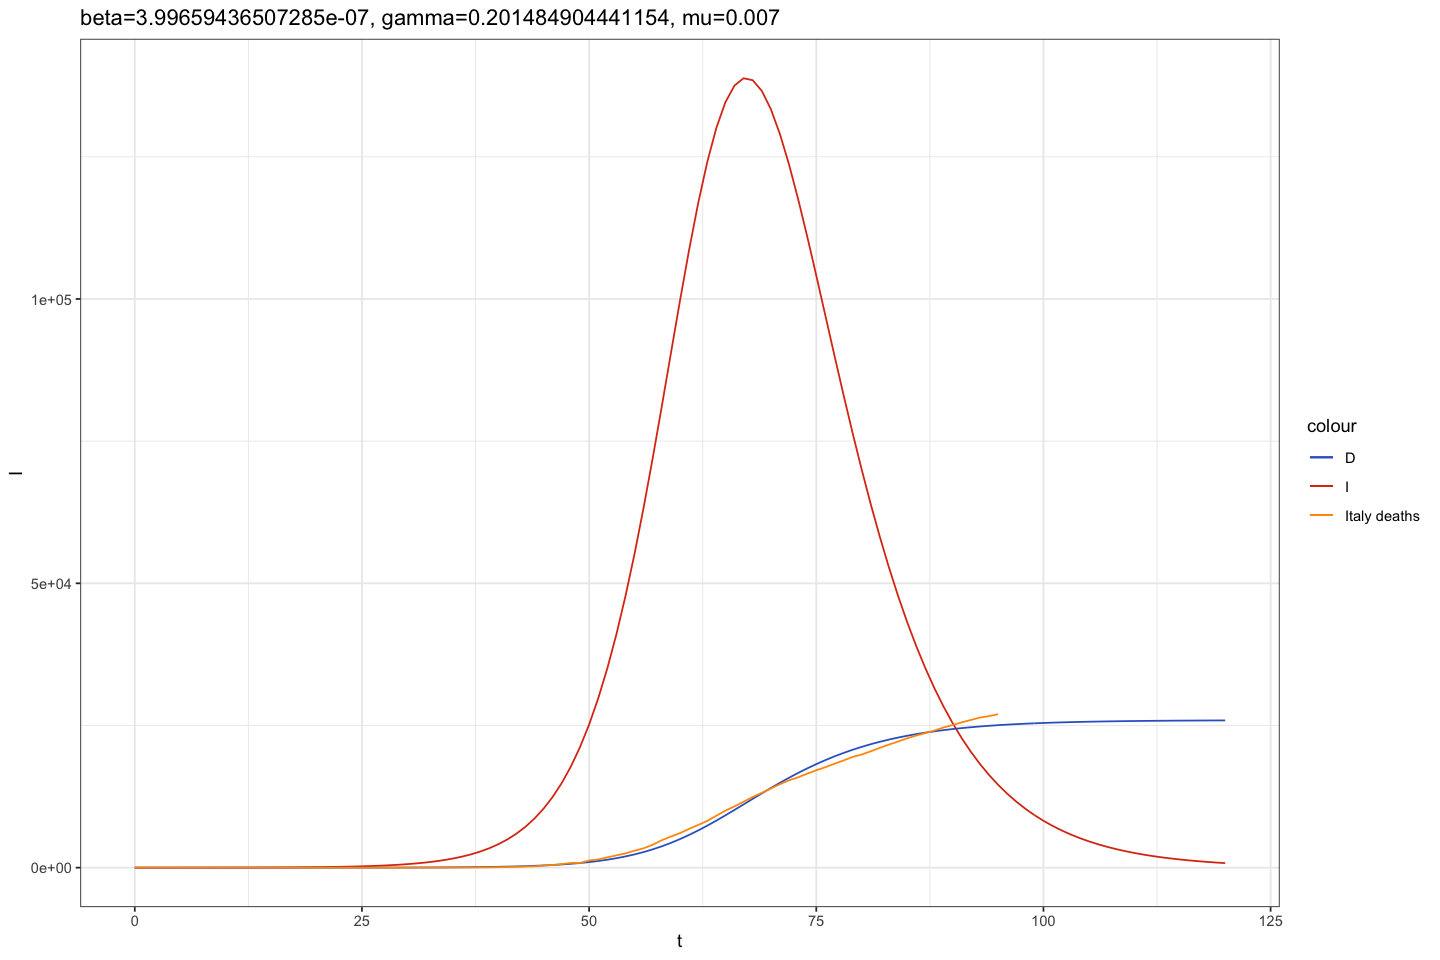

In [748]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
# p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
# p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('beta=', beta.hat, ', gamma=', gamma.hat, ', mu=', mu))
p

## Fit 4: Normal error (beta, gamma, mu)

- Maximize log-likelihood (sum of normal error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Model

In [749]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [750]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [751]:
# Grid where to evaluate
max_time <- 150
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [752]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [753]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [754]:
# log likelihood function
loglik.normal <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dnorm(x=italy$death, mean=subset(s, t >= min(italy$t) & t <= max(italy$t))$D,
              sd=params["sigma"], log=TRUE))
}

In [755]:
# parameter iterative function
f3 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), sigma=sigma)
    -loglik.normal(params)
}

##### Optimization

In [756]:
fit3 <- optim(f3, par=c(-15, -2, -5))
fit3

opt <- fit3$par
R0 <- exp(opt[1]) * N / exp(opt[2])

$par
[1] -15.129484  -3.475576  -6.702608

$value
[1] 427746.3

$counts
function gradient 
     473       NA 

$convergence
[1] 0

$message
NULL

##### Trajectory with optimized beta

In [757]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> sim

Warning message:
“Removed 71 row(s) containing missing values (geom_path).”
Warning message:
“Removed 107 row(s) containing missing values (geom_path).”
Warning message:
“Removed 98 row(s) containing missing values (geom_path).”
Warning message:
“Removed 55 row(s) containing missing values (geom_path).”


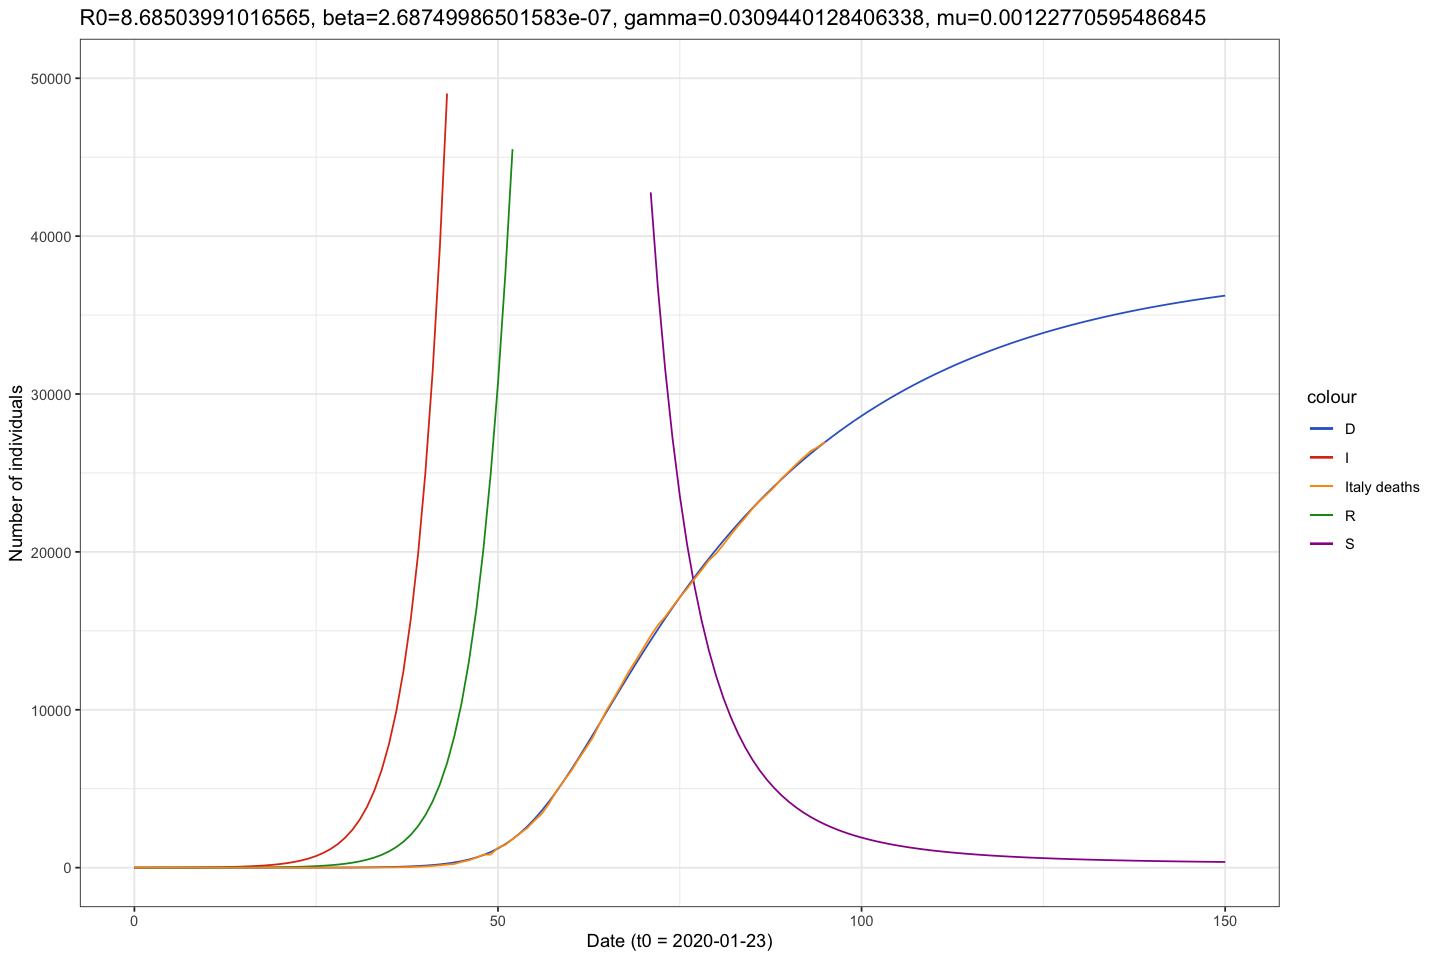

In [758]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(limits=c(0,5e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 55 row(s) containing missing values (geom_path).”


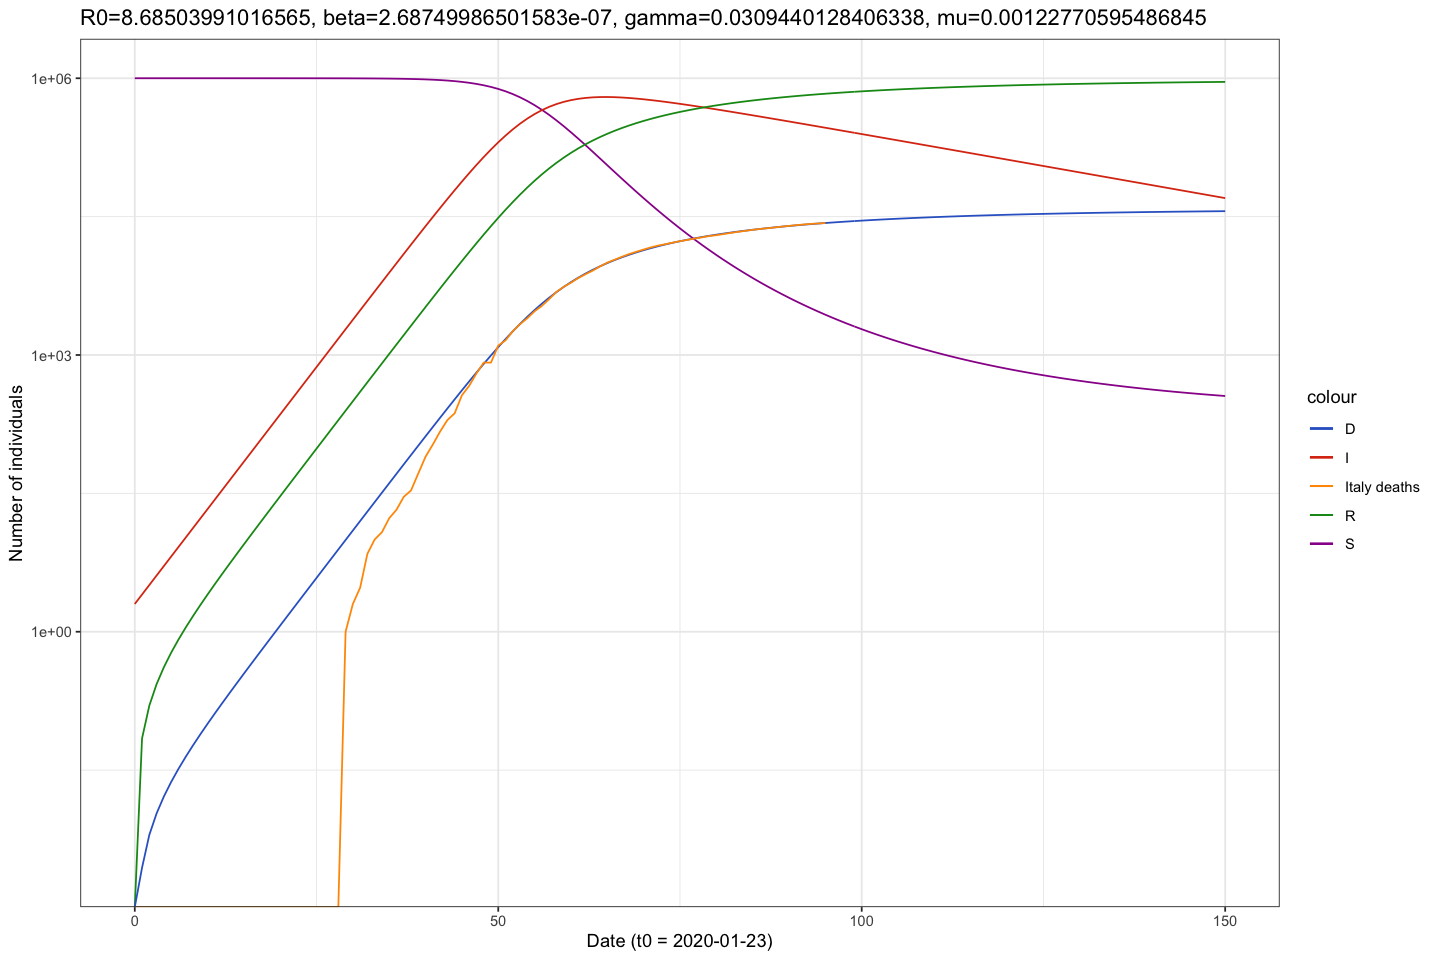

In [759]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(sim, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

## Fit 5: Poisson error (beta, gamma, mu)

- Maximize log-likelihood (sum of poisson error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Poisson error distribution

Since data $y_t$ are a result of a sampling process, we can think of them as binomial samples

$$ y_t \sim \mathrm{Binomial}\left(I(t), \frac{n}{N} \right) $$

where $n$ is sample size, $N$ is population size, $I(t)$ is the true number of infections at time $t$. Alternatively, we might think of $y_t$ as Poisson samples

$$ y_t \sim \mathrm{Poisson}(p, I(t)) $$

where the parameter $p$ reflects a combination of sampling efficiency and the detectability of infections. The latter leads to the following log-likelihood function

##### Model

In [760]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [761]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [762]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [763]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-23')
I0 <- 2


##### Observed

In [764]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [765]:
# log likelihood function
poisson.loglik <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    sum(dpois(x=italy$death, lambda=params["p.scale"]*subset(s, t >= min(italy$t) & t <= max(italy$t))$D, log=TRUE))
}

In [766]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f4 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), p.scale=p.scale)
    -poisson.loglik(params)
}

##### Optimization

In [767]:
# params: beta, gamma, mu
fit4 <- optim(f4, par=c(log(4e-7), log(1/30), log(1e-3)))
fit4

opt <- fit4$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -15.127712  -3.402225  -6.659228

$value
[1] 560.5794

$counts
function gradient 
     198       NA 

$convergence
[1] 0

$message
NULL

[1] 8.085106

In [768]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
2.69e-07 3.33e-02 1.28e-03

In [769]:
opt

[1] -15.127712  -3.402225  -6.659228

##### Confidence intervals

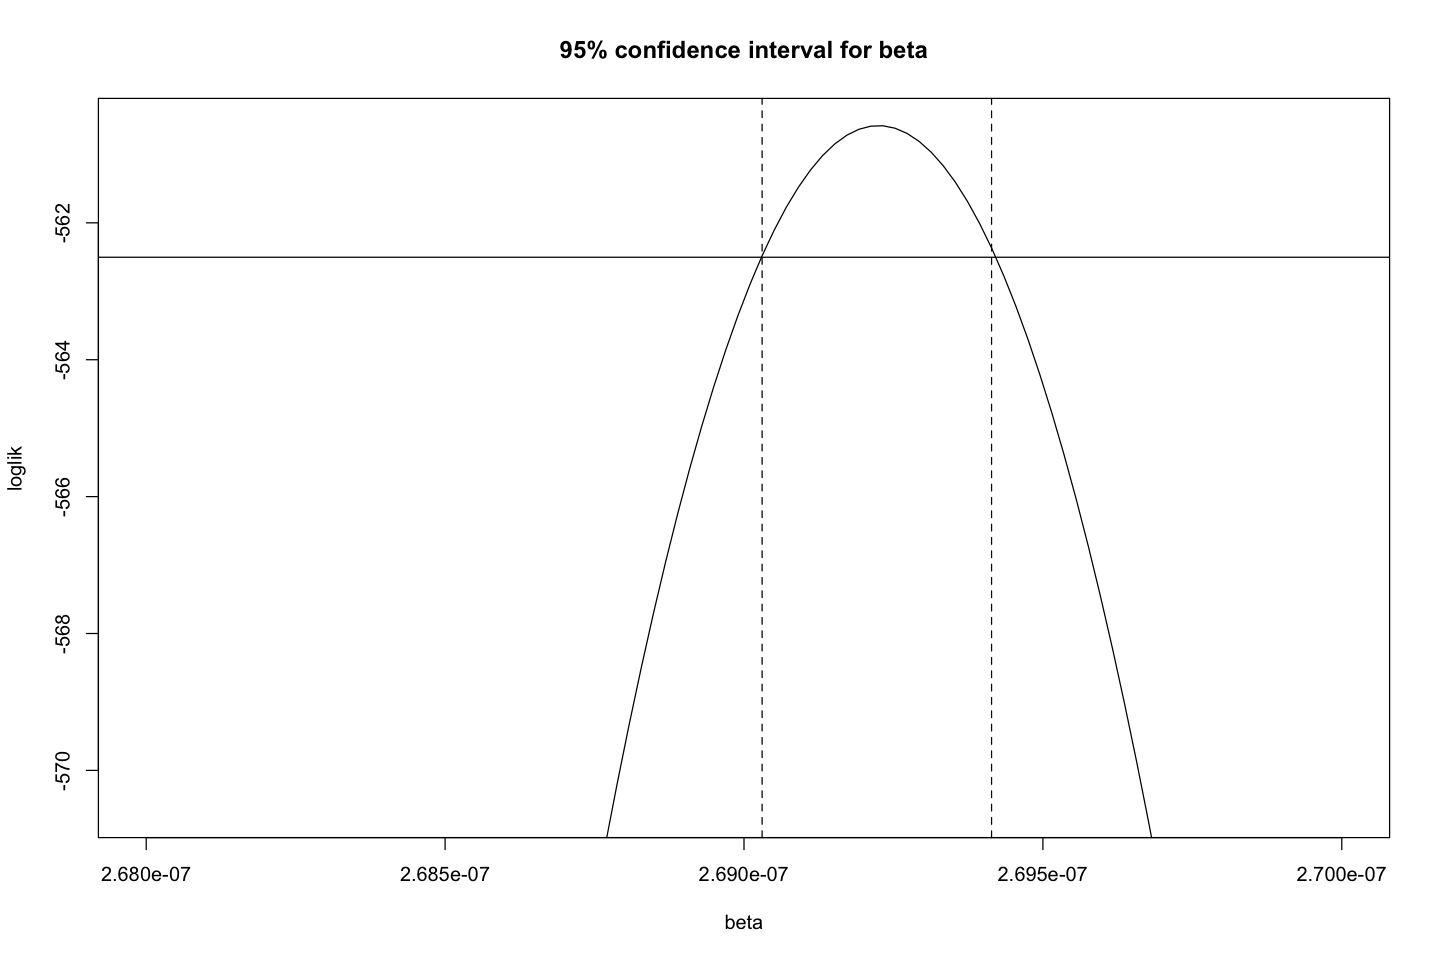

In [773]:
# profile over beta to estimate confidence intervals

prof2.beta <- expand.grid(beta=seq(2.68e-7,2.7e-7,length=100))
fitfn <- function (dat) {
    fit <- optim(fn=function(beta) f4(c(log(dat$beta), opt[2], opt[3], opt[4])),
                 par=mle1[2],method="Brent",lower=0,upper=1)
    c(p=expit(fit$par),loglik=-fit$value)
}

library(plyr)
ddply(prof2.beta,~beta,fitfn) -> prof2.beta
maxloglik <- max(prof2.beta$loglik)
plot(loglik~beta,data=prof2.beta,type="l",ylim=maxloglik+c(-10,0), main='95% confidence interval for beta')
cutoff <- maxloglik-qchisq(p=0.95,df=1)/2
abline(h=c(0,cutoff))
abline(v=range(subset(prof2.beta,loglik>cutoff)$beta),lty=2)

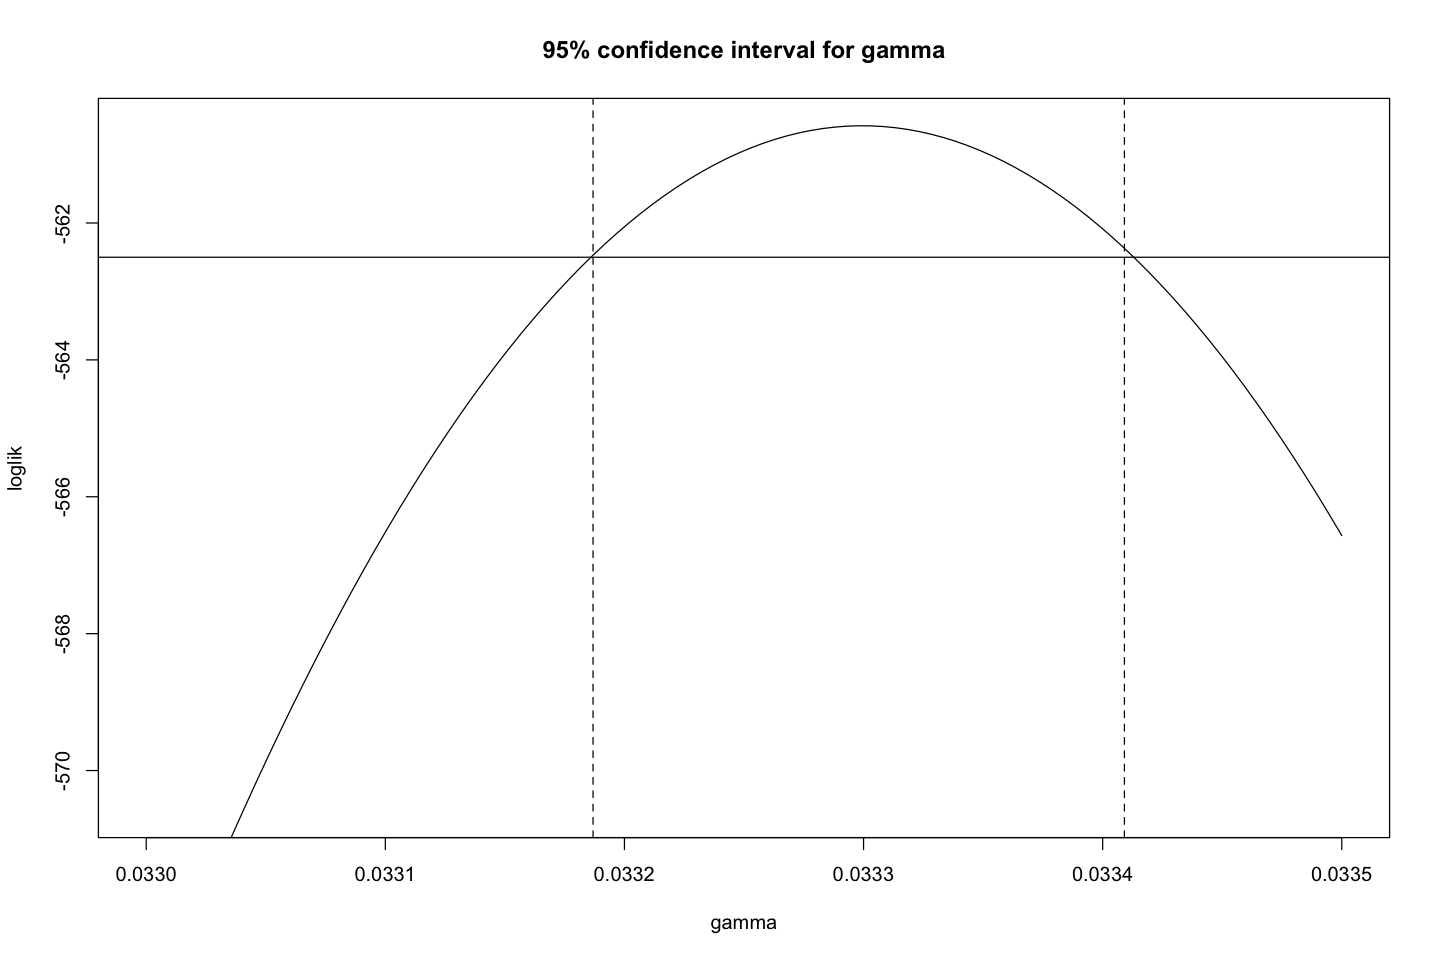

In [776]:
# profile over gamma to estimate confidence intervals

prof2.gamma <- expand.grid(gamma=seq(3.3e-2,3.35e-2,length=100))
fitfn <- function (dat) {
    fit <- optim(fn=function(gamma) f4(c(opt[1], log(dat$gamma), opt[3], opt[4])),
                 par=mle1[2],method="Brent",lower=0,upper=1)
    c(p=expit(fit$par),loglik=-fit$value)
}

library(plyr)
ddply(prof2.gamma,~gamma,fitfn) -> prof2.gamma
maxloglik <- max(prof2.gamma$loglik)
plot(loglik~gamma,data=prof2.gamma,type="l",ylim=maxloglik+c(-10,0), main='95% confidence interval for gamma')
cutoff <- maxloglik-qchisq(p=0.95,df=1)/2
abline(h=c(0,cutoff))
abline(v=range(subset(prof2.gamma,loglik>cutoff)$gamma),lty=2)

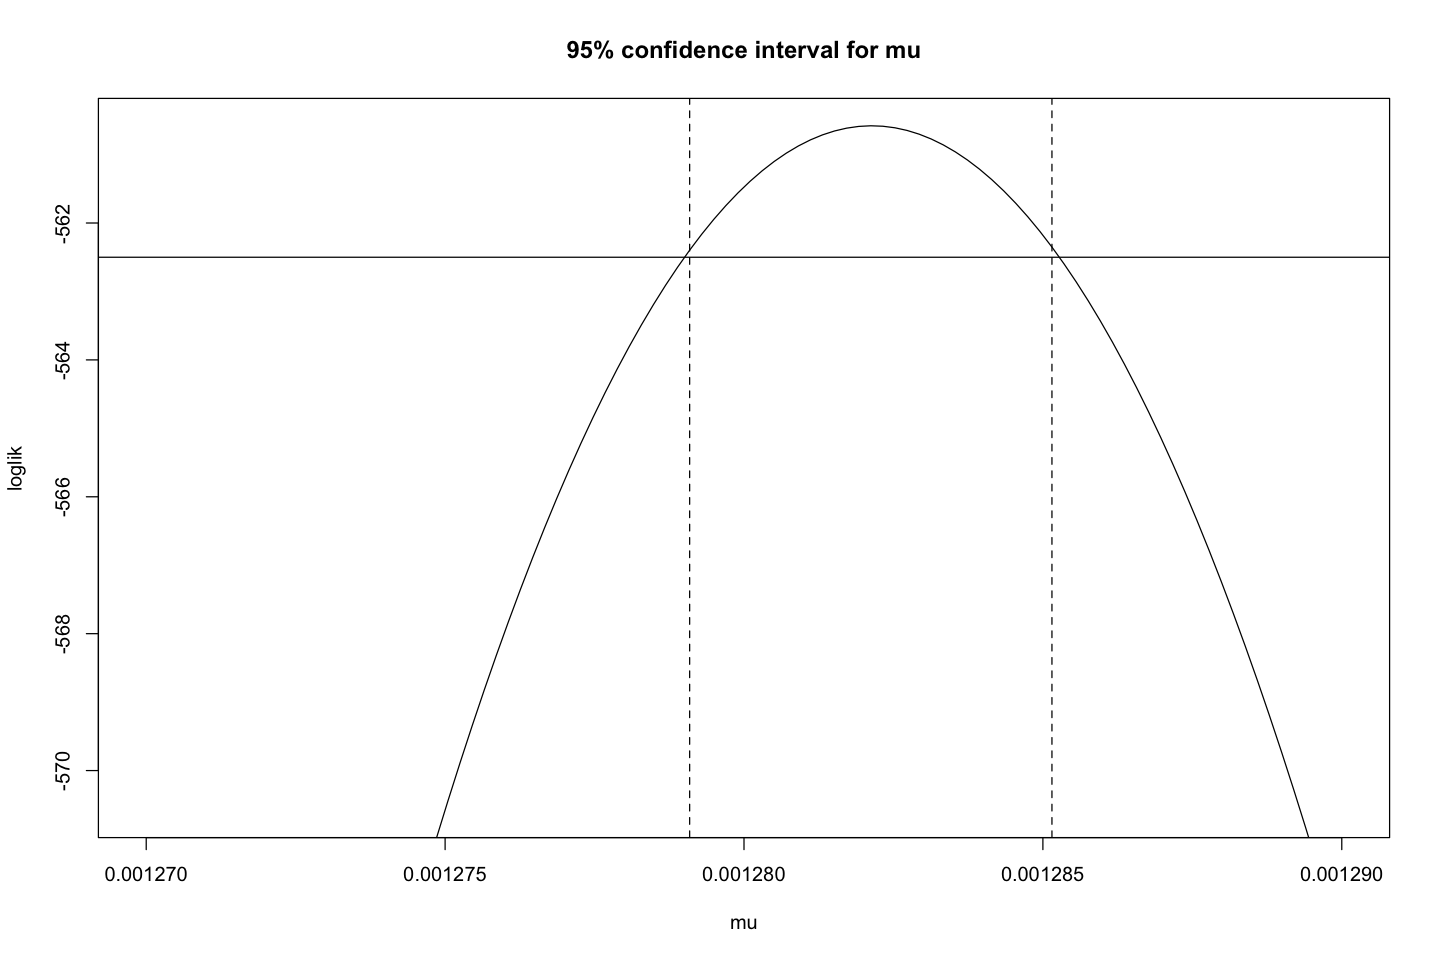

In [775]:
# profile over mu to estimate confidence intervals

prof2.mu <- expand.grid(mu=seq(1.27e-3,1.29e-3,length=100))
fitfn <- function (dat) {
    fit <- optim(fn=function(mu) f4(c(opt[1], opt[2], log(dat$mu), opt[4])),
                 par=mle1[2],method="Brent",lower=0,upper=1)
    c(p=expit(fit$par),loglik=-fit$value)
}

library(plyr)
ddply(prof2.mu,~mu,fitfn) -> prof2.mu
maxloglik <- max(prof2.mu$loglik)
plot(loglik~mu,data=prof2.mu,type="l",ylim=maxloglik+c(-10,0), main='95% confidence interval for mu')
cutoff <- maxloglik-qchisq(p=0.95,df=1)/2
abline(h=c(0,cutoff))
abline(v=range(subset(prof2.mu,loglik>cutoff)$mu),lty=2)

In [777]:
mle1

beta        gamma           mu 
2.692266e-07 3.329908e-02 1.282135e-03

##### Trajectory with optimized beta

In [778]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 71 row(s) containing missing values (geom_path).”
Warning message:
“Removed 77 row(s) containing missing values (geom_path).”
Warning message:
“Removed 68 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


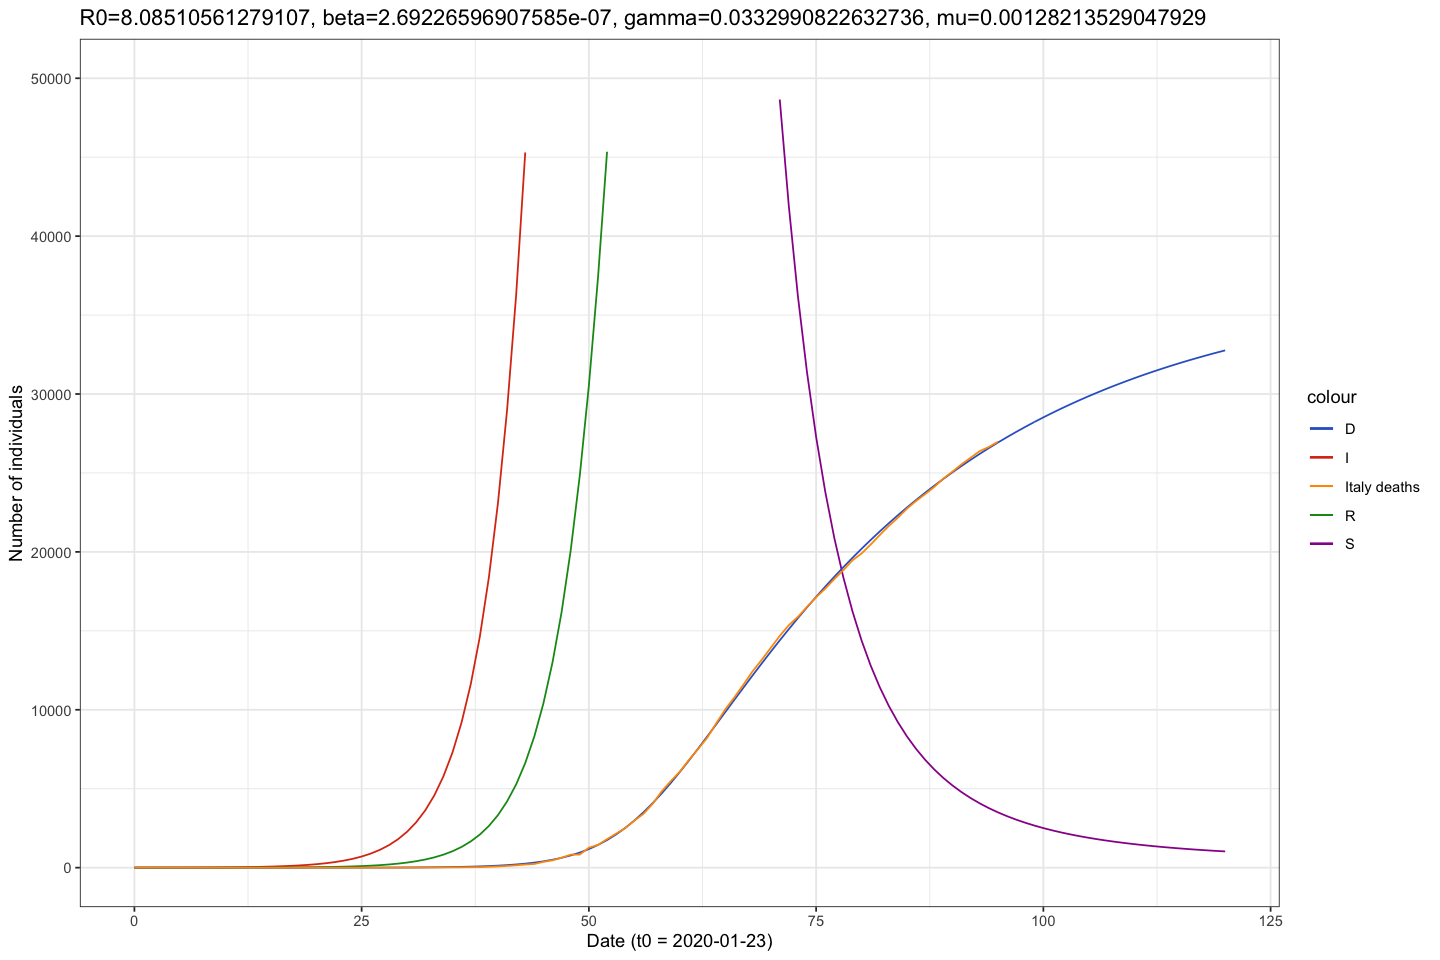

In [779]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(pred, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(limits=c(0,5e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


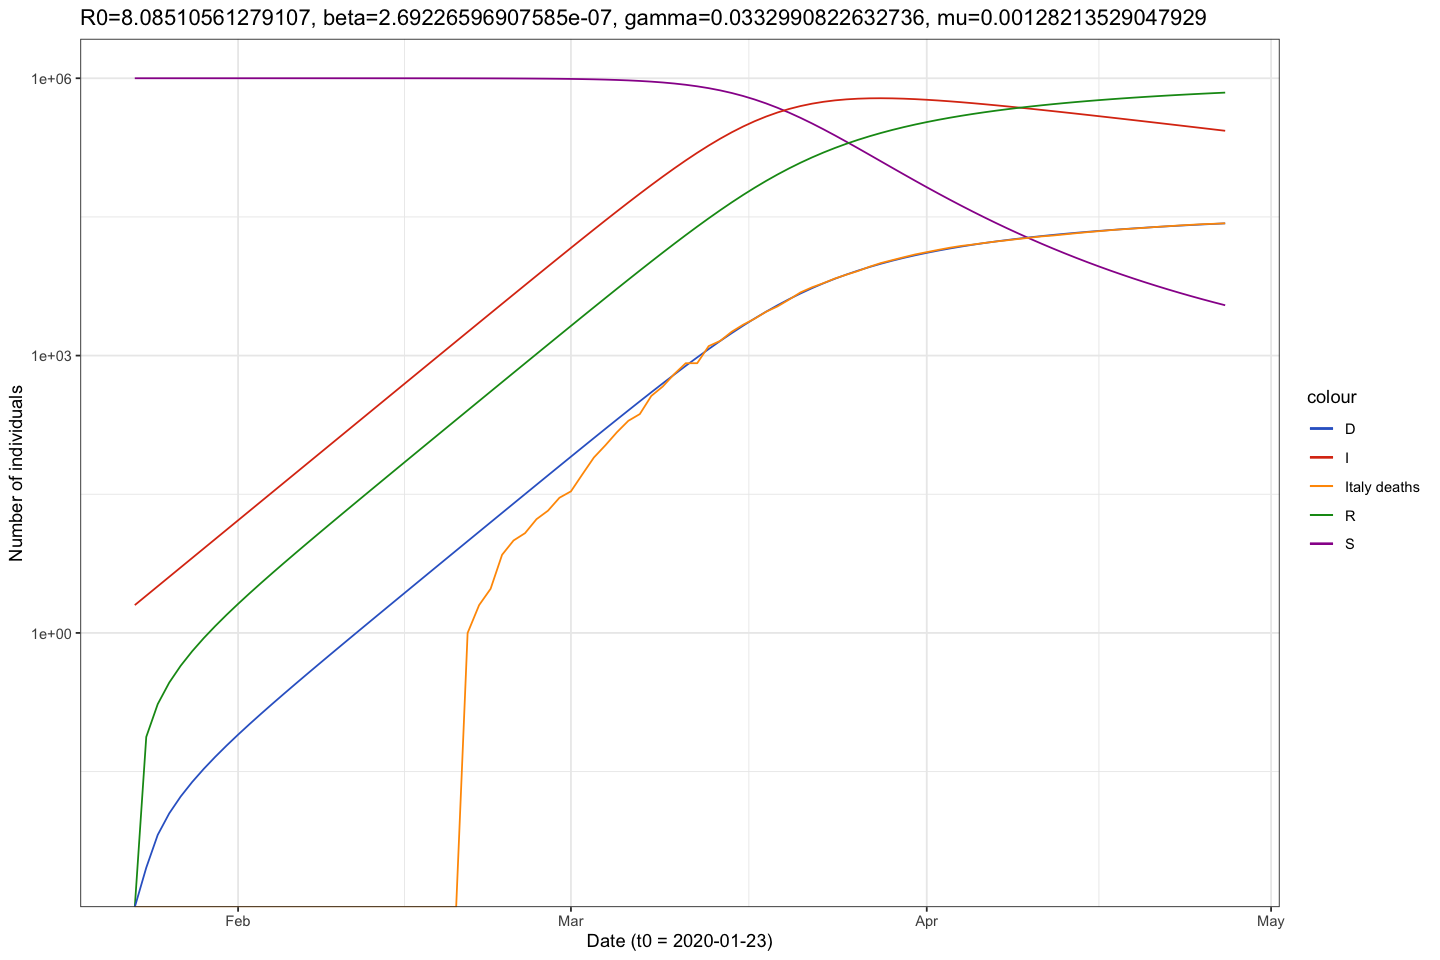

In [780]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(pred, italy, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

##### Predicted probability distribution plot

Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


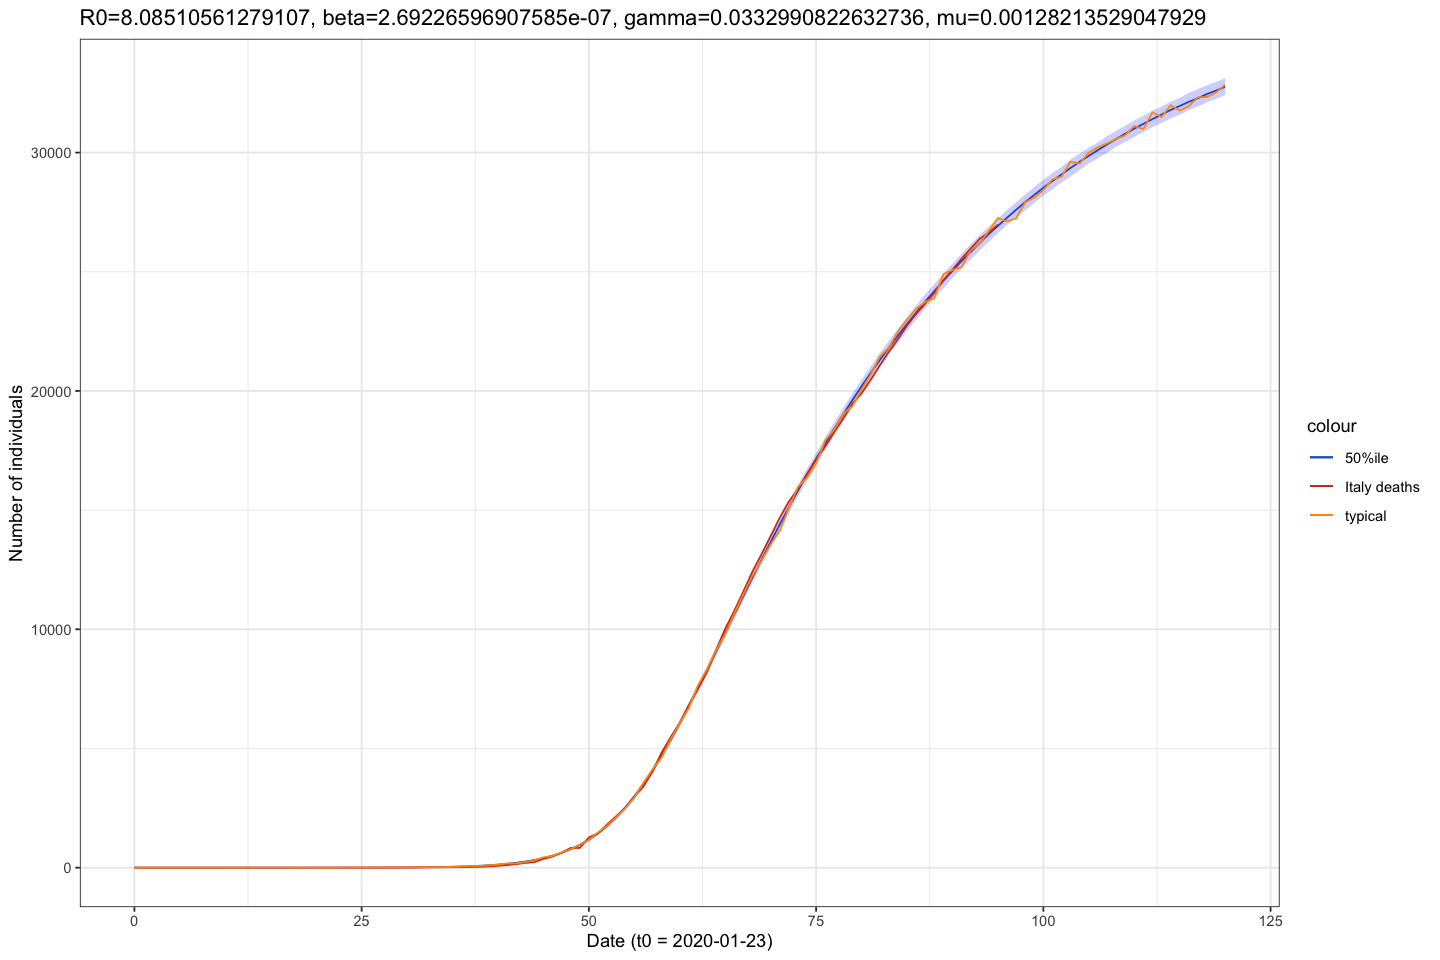

In [781]:
# run 2000 simulations of optimized parameters

raply(2000,rpois(n=length(pred$D),lambda=p.scale * pred$D)) -> simdat
aaply(simdat,2,quantile,probs=c(0.025,0.5,0.975)) -> quantiles

typ <- sample(nrow(simdat),1)

p <- ggplot(data=cbind(join(pred, italy, by='t'),
                       quantiles,
                       typical=simdat[typ,]),
            mapping=aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=`50%`, col='50%ile'))
p <- p + geom_ribbon(aes(ymin=`2.5%`,ymax=`97.5%`), fill='blue', alpha=0.2)
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + geom_line(aes(y=typical, col='typical'))
p <- p + labs(y="Deaths",x="t")
# p <- p + scale_x_continuous(limit=c(70,80))
# p <- p + scale_y_continuous(limit=c(1.2e4,1.7e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

## Fit 6: Vary N with Poisson error (N, beta, gamma, mu)

I'm not sure how choice of $N$ (population size) affects these estimates, and choice of 1e6 was arbitrary.

Let's allow $N$ to vary and evaluate how this changes our results. We'll continue to use the same Poisson error model in Fit 5.

The actual population of Italy is 60.3 million [[source](https://en.wikipedia.org/wiki/Demographics_of_Italy)]. This might not be the effective population, but let's allow this to vary and see what happens.

- Maximize log-likelihood (sum of poisson error)
- Optimize $S_0$, $\beta$, $\gamma$, and $\mu$ simultaneously
- We're probably in danger of overfitting here

Results of this seem to show that when $N \gt 20,000,000$, it struggles to achieve good fit with reasonable parameter values ($R_0$ goes to ~30, $1/\gamma$ approaches 100 days)

Several possible causes:
- Actual susceptible population is much less than total population of Italy
- Infection spreading through population via semi-isolated communities, leading to $e^{e^e}$ order spread

One solution might be to use more isolated populations, such as county or province-level data.

##### Model

In [782]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [783]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [784]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-23, as this was the date that two COVID-19 positive Chinese tourists arrived in Milan.

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Italy#First_confirmed_cases

In [785]:
# Variables

# Population size 
N <- 40e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/14
# Infectious contact rate: beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 2.5/N*gamma
mu <- 1e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-23')
I0 <- 2

##### Observed

In [786]:
# Select Italy data from JHU dataset

subset(gdeath, region=='Italy') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> italy

##### Functions

In [787]:
# log likelihood function
poisson.loglik <- function (params) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(params['N'] - I0, I0, 0, 0)) -> s

    sum(dpois(x=italy$death, lambda=params["p.scale"]*subset(s, t >= min(italy$t) & t <= max(italy$t))$D, log=TRUE))
}

In [788]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f4 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), N=N, p.scale=p.scale)
    -poisson.loglik(params)
}

##### Optimization

In [789]:
# params: beta, gamma, mu
fit4 <- optim(f4, par=c(log(beta), log(gamma), log(mu)))
fit4

opt <- fit4$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -17.945641  -0.932053  -7.990361

$value
[1] 6806.771

$counts
function gradient 
     109       NA 

$convergence
[1] 0

$message
NULL

[1] 1.633626

In [790]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
1.61e-08 3.94e-01 3.39e-04

In [791]:
opt

[1] -17.945641  -0.932053  -7.990361

##### Trajectory with optimized beta

In [792]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 121 row(s) containing missing values (geom_path).”
Warning message:
“Removed 84 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


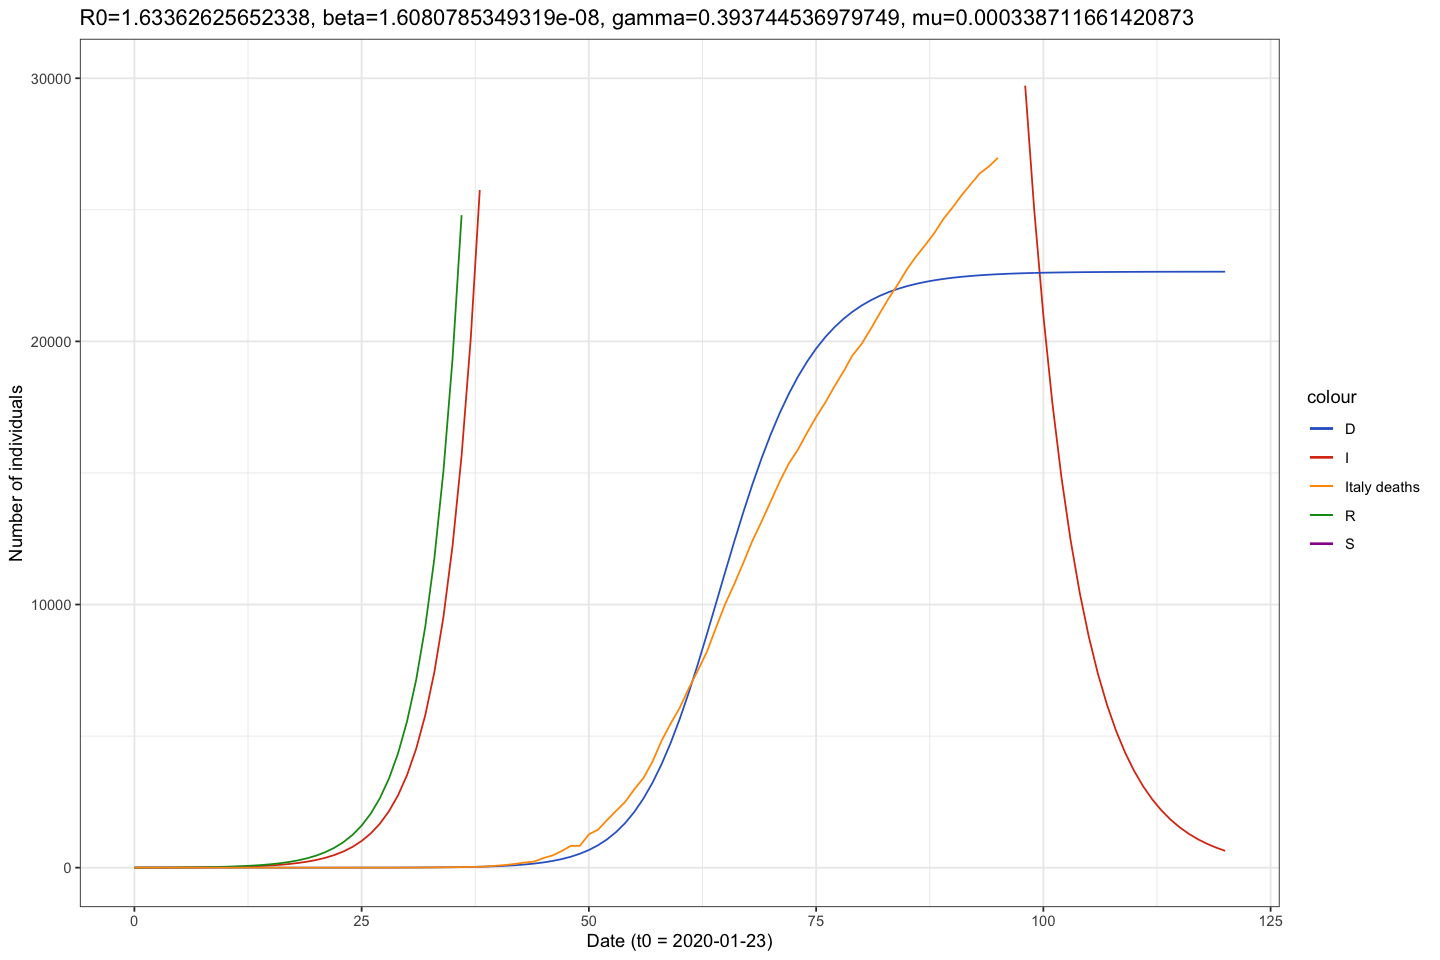

In [793]:
# plot the simulated data compared to the observed (italy) data
p <- ggplot(join(pred, italy, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(limits=c(0,3e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”
Warning message:
“Removed 25 row(s) containing missing values (geom_path).”


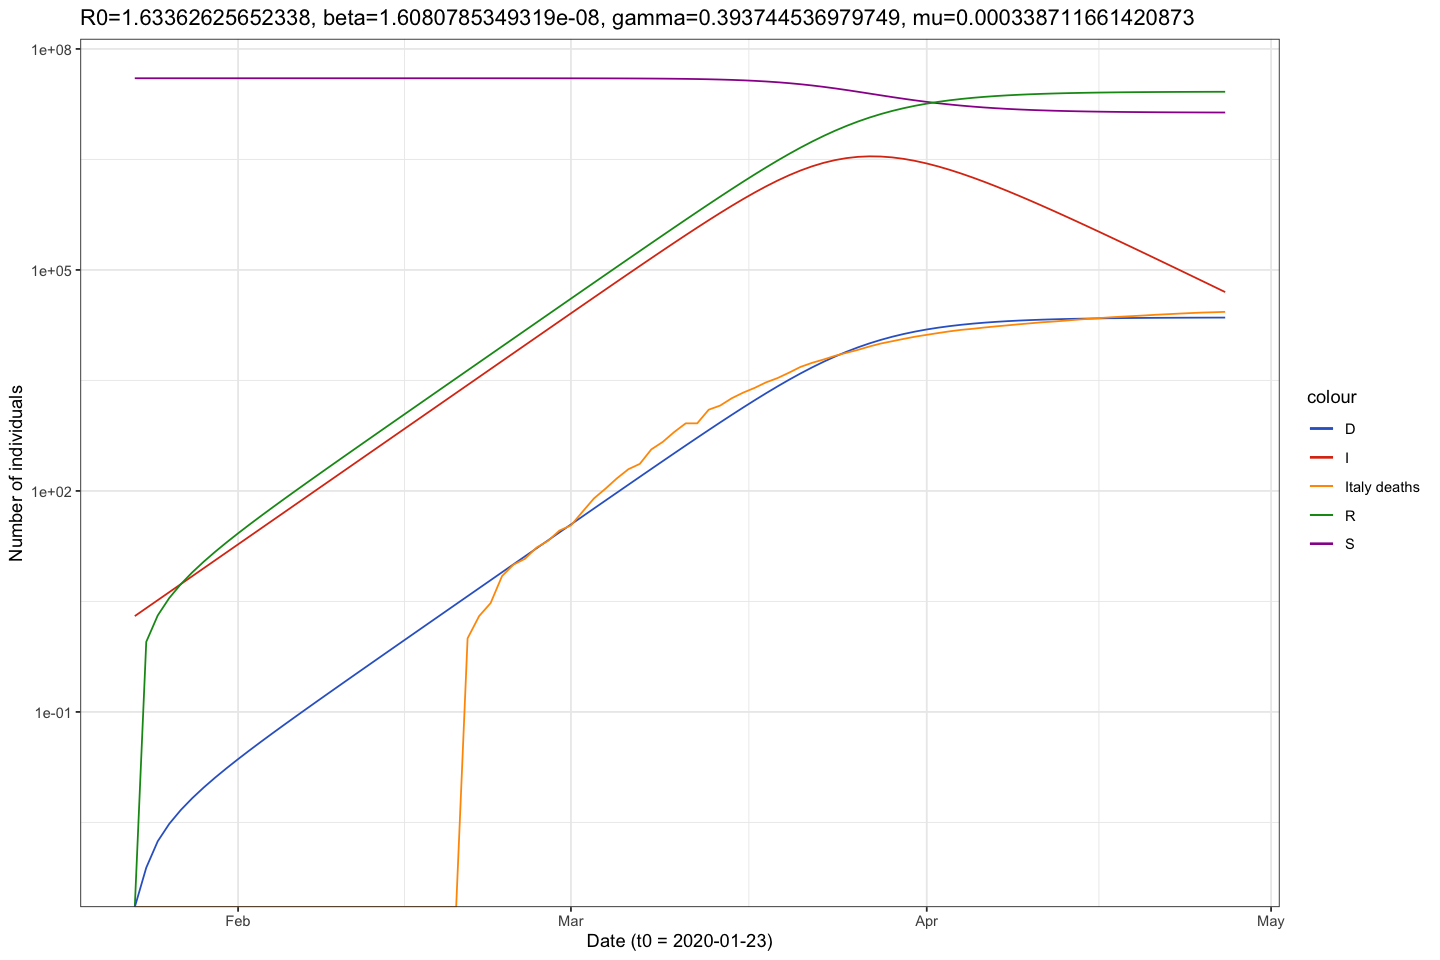

In [794]:
# plot the simulated data compared to the observed (italy) data (log transformed)
p <- ggplot(join(pred, italy, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col='Italy deaths'))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab('Date (t0 = 2020-01-23)') + ylab('Number of individuals')
p

## Fit 7: Negative binomial model

- Maximize log-likelihood (sum of negbin error)
- Optimize $\beta$, $\gamma$, and $\mu$ simultaneously

##### Negative binomial distribution

Poisson assumes that the variance of the error is equal to the mean $\lambda$. The **negative binomial distribution** allows for more variability than Poisson. Let's assume that $y_t$ is negative-binomially distributed with mean $p I(t)$ (as before), but with larger variance, $p I(t) (1 + \theta p I(t))$:

$$ y_t \sim \mathrm{Negbin}\left( \mathrm{mean} = p I(t) \text{, size = } \frac{1}{\theta} \right) $$

In [380]:
# to do

# Other geographic sites

So far we've been looking at Italy because the early outbreak provides a more mature dataset for infection dynamics. We'd like to refine our estimation using addition sites, treating them as independent trials that are bound by similar parameters ($\mu$, $\gamma$, $\beta$).

In reality, this is an oversimplification, since these sites are not truly independent (due to intermixing between communities) and differences in population demographics, healthcare systems, social distancing regulation may affect parameters. However, this strategy also has several advantages (easier to estimate effective population size, assumptions of homogenous mixing are more valid, multiple datasets reduce overfitting) and can inform some of the yet unknown underlying characteristics of SARS-CoV-2.

## Spain

- Poisson error model
- Max log-likelihood of $\beta$, $\mu$, $\gamma$

##### Model

In [795]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [796]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [797]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-31, as this was the date of first confirmed positive case (German tourist in the Canary Islands).

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Spain#First_cases_(31_January_%E2%80%93_25_February)

In [798]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-31')
I0 <- 2


##### Observed

In [799]:
# Select data from JHU dataset

subset(gdeath, region=='Spain') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> mysite
mysite.name <- 'Spain'

##### Functions

In [800]:
# log likelihood function
poisson.loglik <- function (params, site) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    
    sum(dpois(x=site$death,
              lambda=params["p.scale"]*subset(s, t >= min(site$t) & t <= max(site$t))$D,
              log=TRUE))
}

In [801]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f5 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), p.scale=p.scale)
    -poisson.loglik(params, mysite)
}

##### Optimization

In [803]:
# params: beta, gamma, mu
fit5 <- optim(f5, par=c(log(3e-7), log(1/30), log(1e-3)))
fit5

opt <- fit5$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -14.985260  -2.569316  -6.136380

$value
[1] 1618.577

$counts
function gradient 
     266       NA 

$convergence
[1] 0

$message
NULL

[1] 4.053443

In [804]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
3.10e-07 7.66e-02 2.16e-03

In [805]:
opt

[1] -14.985260  -2.569316  -6.136380

##### Trajectory with optimized beta

In [806]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 84 row(s) containing missing values (geom_path).”
Warning message:
“Removed 72 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”


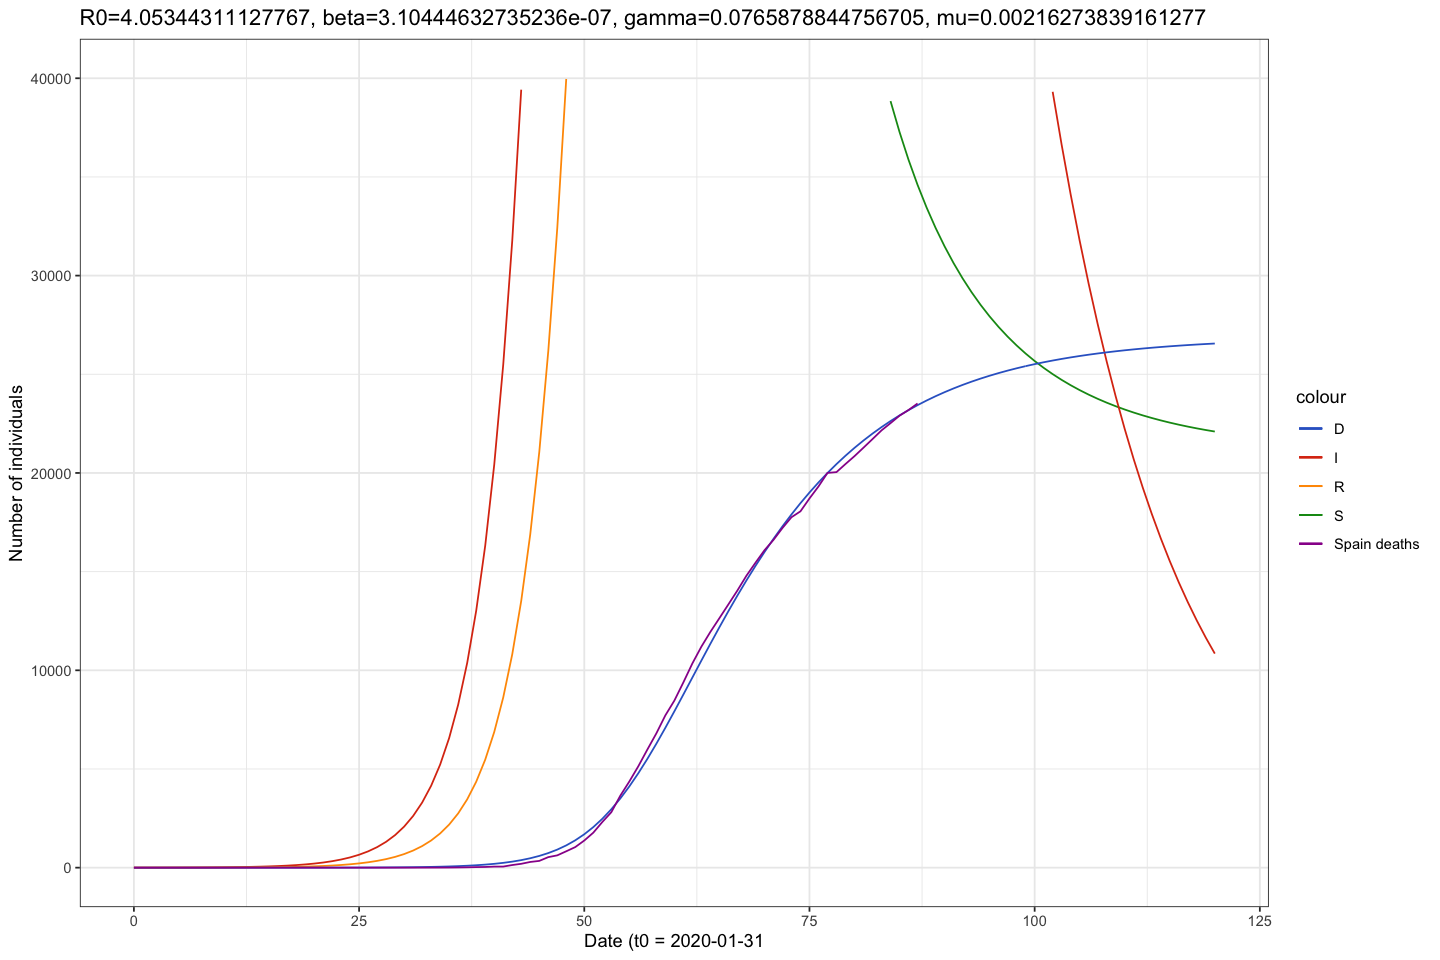

In [807]:
# plot the simulated data compared to the observed data
p <- ggplot(join(pred, mysite, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(limits=c(0,4e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”


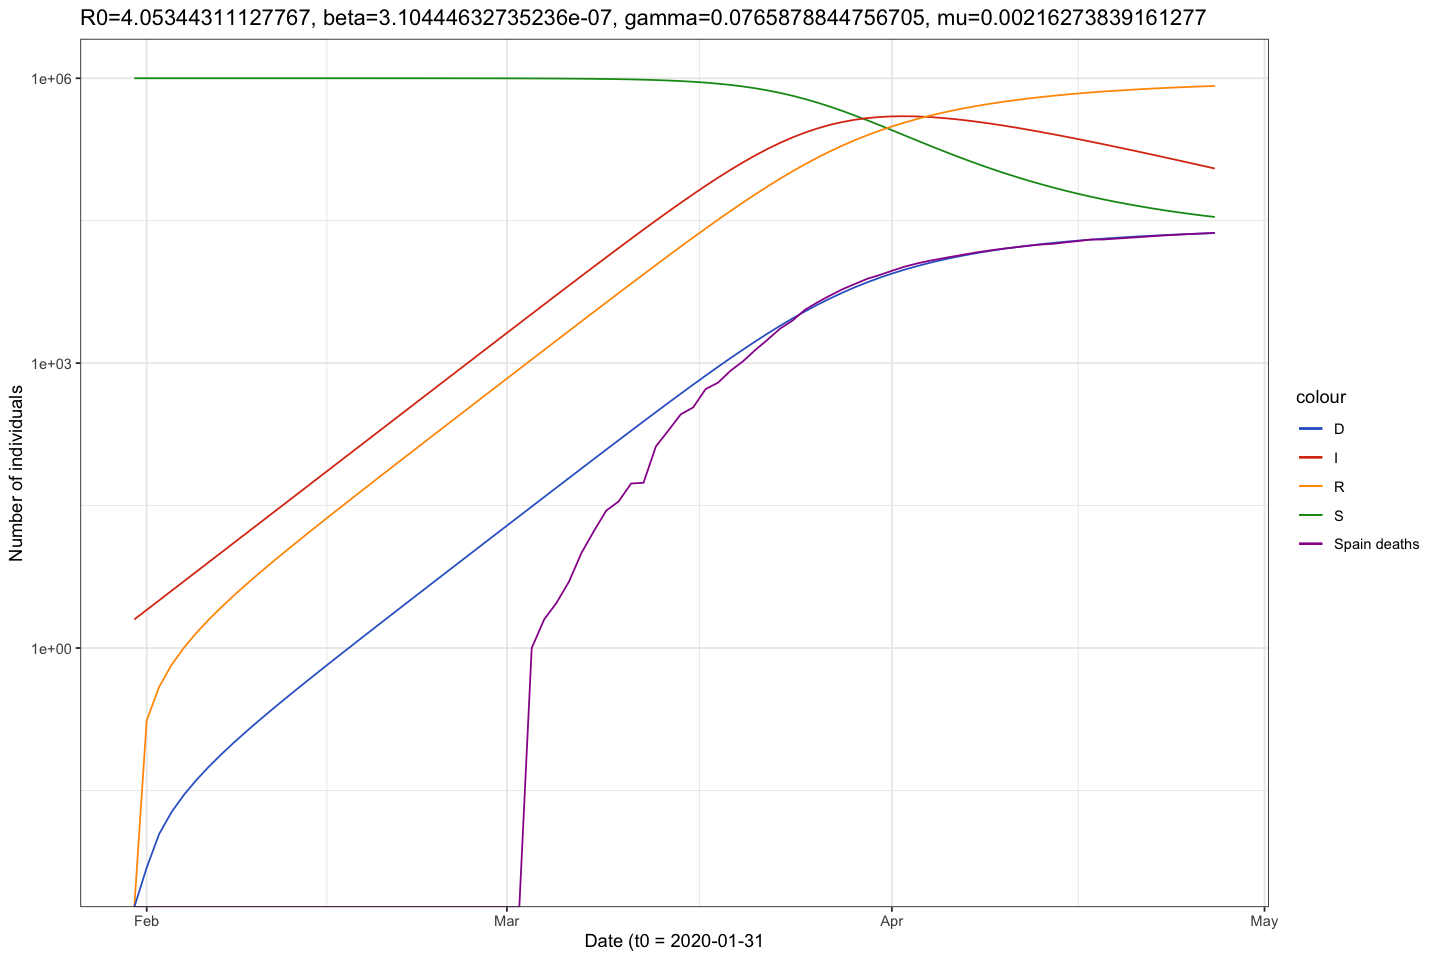

In [808]:
# plot the simulated data compared to the observed data (log transformed)
p <- ggplot(join(pred, mysite, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

##### Predicted probability distribution plot

Warning message:
“Removed 33 row(s) containing missing values (geom_path).”


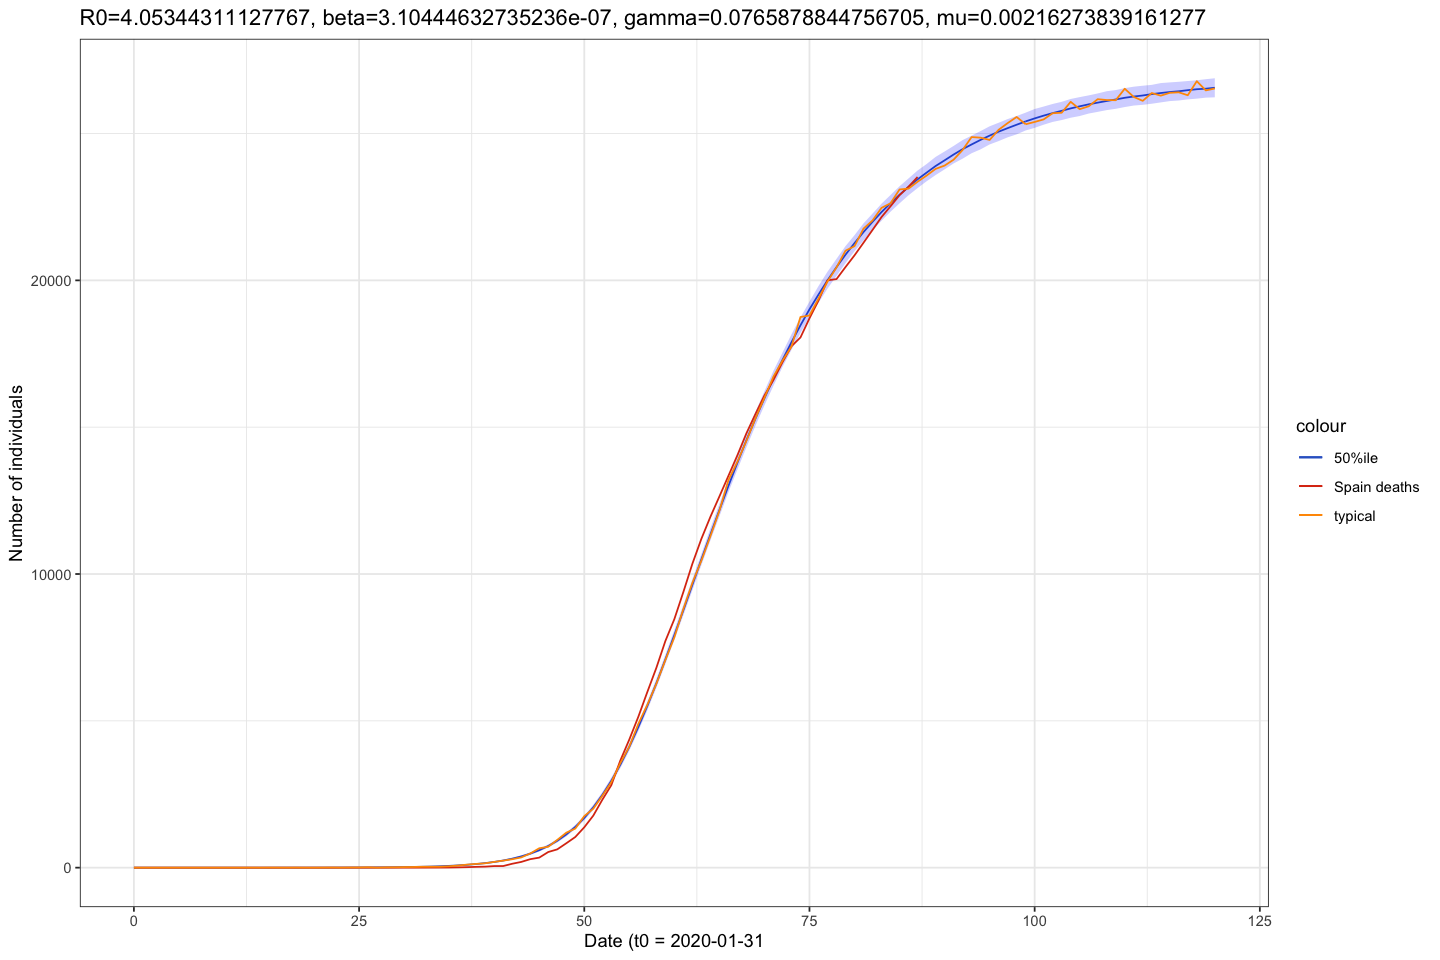

In [809]:
# run 2000 simulations of optimized parameters

raply(2000,rpois(n=length(pred$D),lambda=p.scale * pred$D)) -> simdat
aaply(simdat,2,quantile,probs=c(0.025,0.5,0.975)) -> quantiles

typ <- sample(nrow(simdat),1)

p <- ggplot(data=cbind(join(pred, mysite, by='t'),
                       quantiles,
                       typical=simdat[typ,]),
            mapping=aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=`50%`, col='50%ile'))
p <- p + geom_ribbon(aes(ymin=`2.5%`,ymax=`97.5%`), fill='blue', alpha=0.2)
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + geom_line(aes(y=typical, col='typical'))
p <- p + labs(y="Deaths",x="t")
# p <- p + scale_x_continuous(limit=c(70,80))
# p <- p + scale_y_continuous(limit=c(1.2e4,1.7e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

## Germany

- Poisson error model
- Max log-likelihood of $\beta$, $\mu$, $\gamma$

##### Model

In [810]:
m1 <- function(t, y, params) {
    beta <- params[1]
    gamma <- params[2]
    mu <- params[3]
    S <- y[1]
    I <- y[2]
    R <- y[3]
    D <- y[4]
    return(list(c(S = -beta * S * I, I = beta * S * I - (gamma + mu) * I, R = gamma * I, D = mu * I)))
}

In [811]:
# Solve ODE system using Runge-Kutta numerical method.

trajectory <- function(model, params, init, times, pop.names) {
    rk4(y = init, times = times, func = model, parms = params) %>%
    as.data.frame() %>%
    setNames(c("t", pop.names)) -> output
    return(output)
}

##### Variables

In [812]:
# Grid where to evaluate
max_time <- 120
resolution <- 1
times <- seq(0, max_time, by=resolution)

We'll set $t_0$ as 2020-01-31, as this was the date of first confirmed positive case (German tourist in the Canary Islands).

https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_Spain#First_cases_(31_January_%E2%80%93_25_February)

In [813]:
# Population size 
N <- 1e6 
# Rate at which person stays in the infectious compartment (disease specific and tracing specific)
gamma <- 1/5 
# Infectious contact rate - beta = R0/N*gamma and when R0 \approx 2.25 then  2.25/N*gamma
beta <- 3.9e-07
mu <- 7e-3
# R0 for the beta and gamma values
R0 <- beta*N/gamma

sigma <- 1
p.scale <- 1 # lambda scaling coefficient for Poisson distribution

t0 <- as.Date('2020-01-31')
I0 <- 2


##### Observed

In [814]:
# Select data from JHU dataset

subset(gdeath, region=='Germany') %>%
select(date, death) %>%
mutate(t=as.numeric(date - t0)) %>%
subset(t >=0 & t <= max_time) -> mysite
mysite.name <- 'Germany'

##### Functions

In [815]:
# log likelihood function
poisson.loglik <- function (params, site) {
    trajectory(
        model=m1,
        params=params,
        times=times,
        pop.names=c('S', 'I', 'R', 'D'),
        init=c(N - I0, I0, 0, 0)) -> s

    
    sum(dpois(x=site$death,
              lambda=params["p.scale"]*subset(s, t >= min(site$t) & t <= max(site$t))$D,
              log=TRUE))
}

In [816]:
# parameter iterative function

logit <- function (p) log(p/(1-p))    # the logit transform
expit <- function (x) 1/(1+exp(-x))   # inverse logit

f5 <- function (par) {
    params <- c(beta=exp(par[1]), gamma=exp(par[2]), mu=exp(par[3]), p.scale=p.scale)
    -poisson.loglik(params, mysite)
}

##### Optimization

In [817]:
# params: beta, gamma, mu
fit5 <- optim(f5, par=c(log(3e-7), log(1/30), log(1e-3)))
fit5

opt <- fit5$par
R0 <- exp(opt[1]) * N / exp(opt[2])

R0

$par
[1] -15.278441  -3.958746  -8.026537

$value
[1] 452.5504

$counts
function gradient 
     378       NA 

$convergence
[1] 0

$message
NULL

[1] 12.13162

In [818]:
mle1 <- c(beta=exp(opt[1]), gamma=exp(opt[2]), mu=exp(opt[3]))
signif(mle1,3)

beta    gamma       mu 
2.32e-07 1.91e-02 3.27e-04

In [819]:
opt

[1] -15.278441  -3.958746  -8.026537

##### Trajectory with optimized beta

In [820]:
# simulation dataframe to model based on our input parameters
trajectory(
    model=m1,
    params=exp(opt),
    times=times,
    pop.names=c('S', 'I', 'R', 'D'),
    init=c(N - I0, I0, 0, 0)) -> pred

Warning message:
“Removed 79 row(s) containing missing values (geom_path).”
Warning message:
“Removed 74 row(s) containing missing values (geom_path).”
Warning message:
“Removed 61 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”


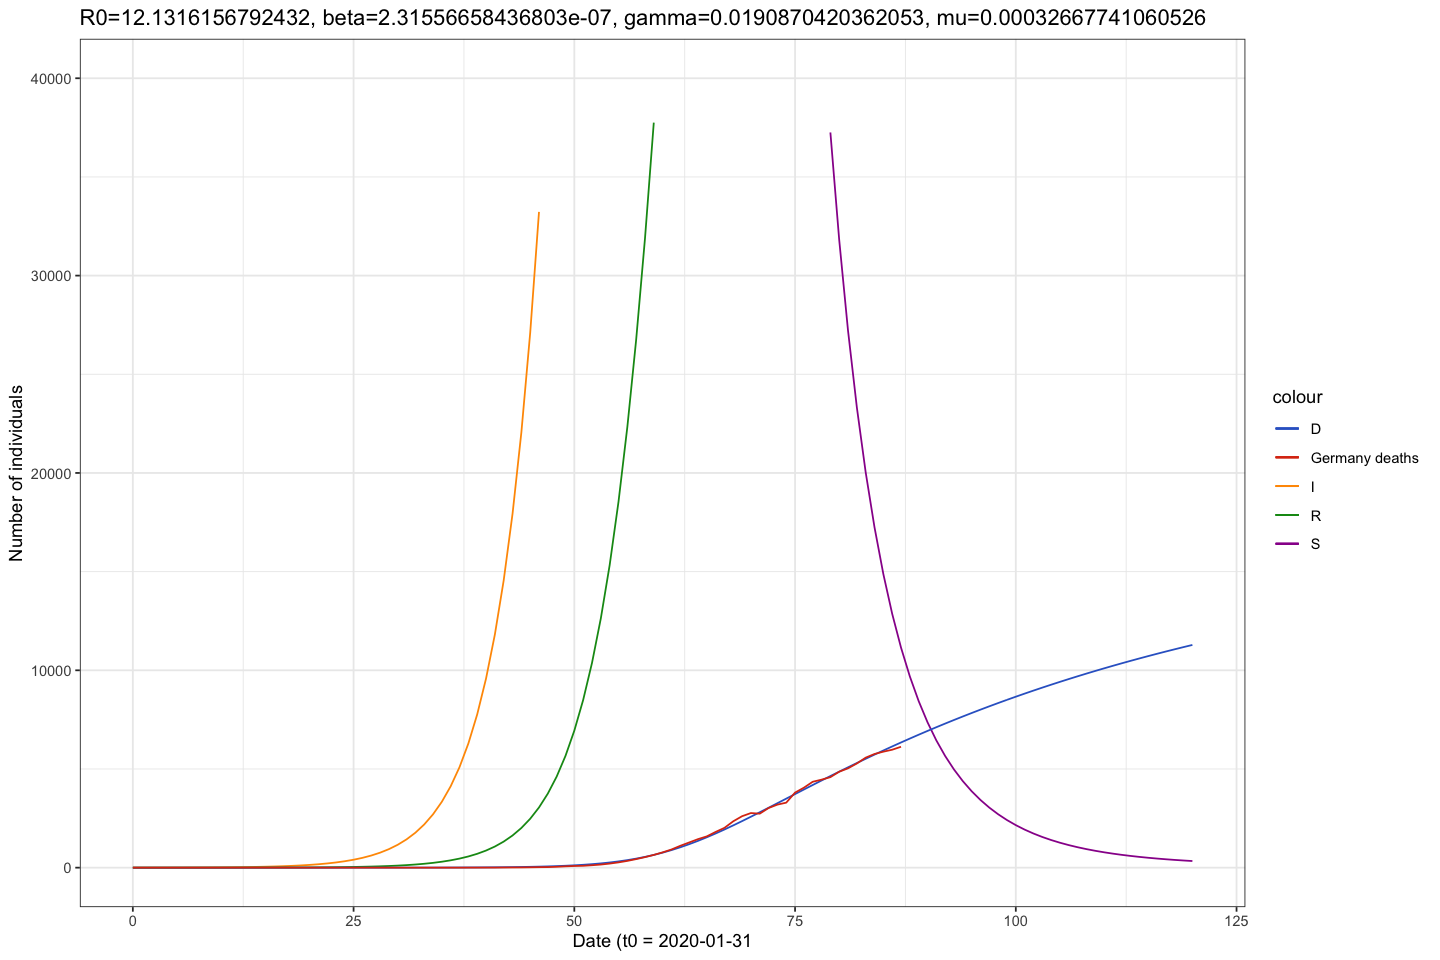

In [821]:
# plot the simulated data compared to the observed data
p <- ggplot(join(pred, mysite, by='t'), aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(limits=c(0,4e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”
Warning message:
“Removed 33 row(s) containing missing values (geom_path).”


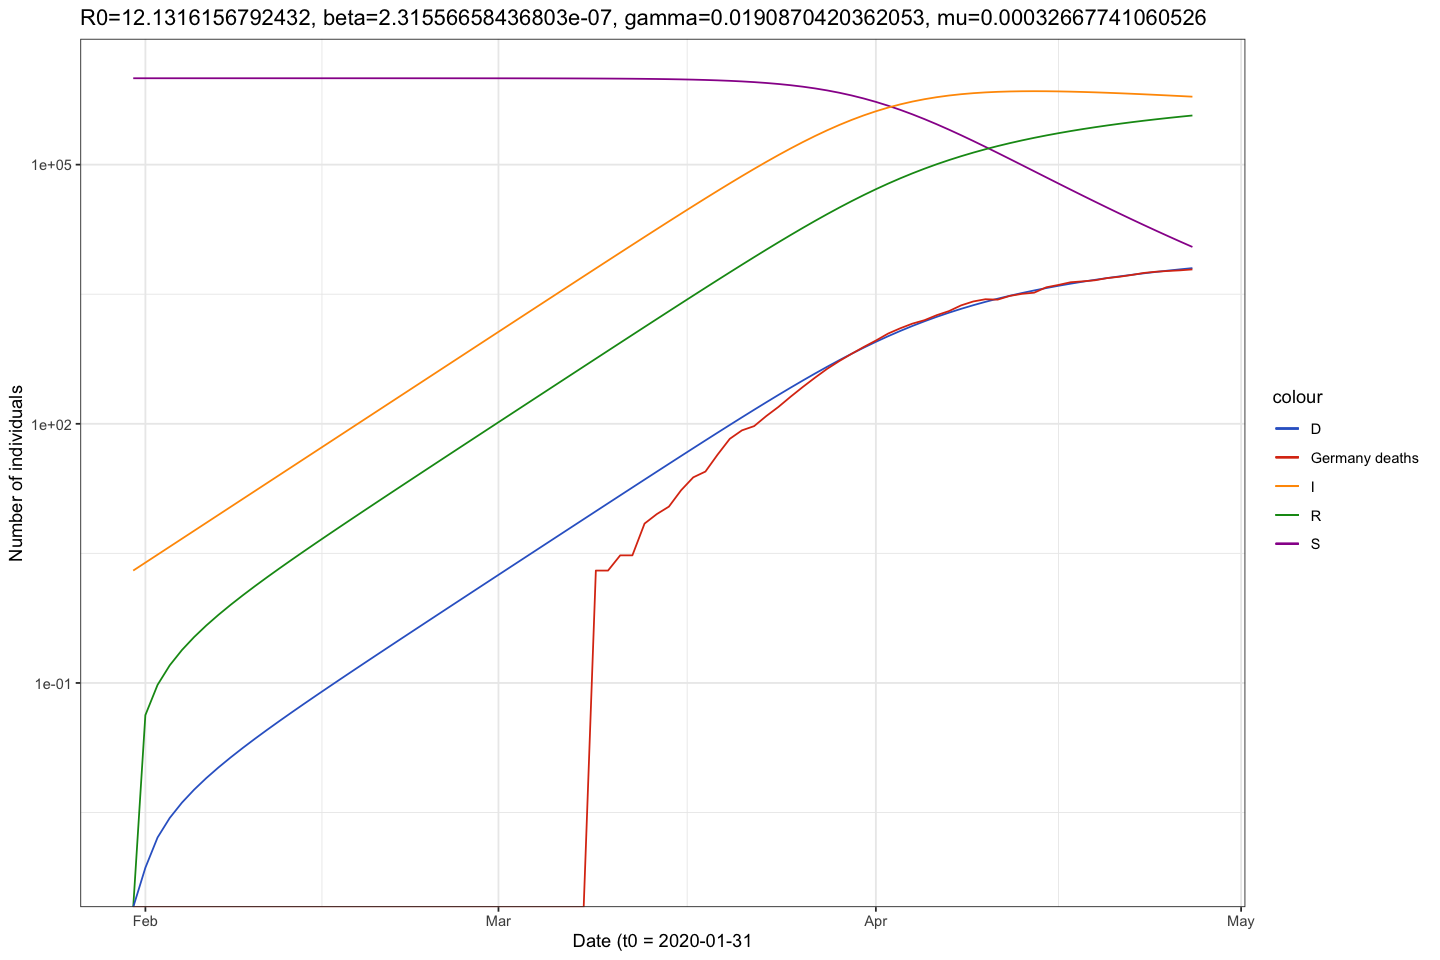

In [822]:
# plot the simulated data compared to the observed data (log transformed)
p <- ggplot(join(pred, mysite, by='t'), aes(x=date))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=S, col='S'))
p <- p + geom_line(aes(y=I, col='I'))
p <- p + geom_line(aes(y=R, col='R'))
p <- p + geom_line(aes(y=D, col='D'))
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

##### Predicted probability distribution plot

Warning message:
“Removed 33 row(s) containing missing values (geom_path).”


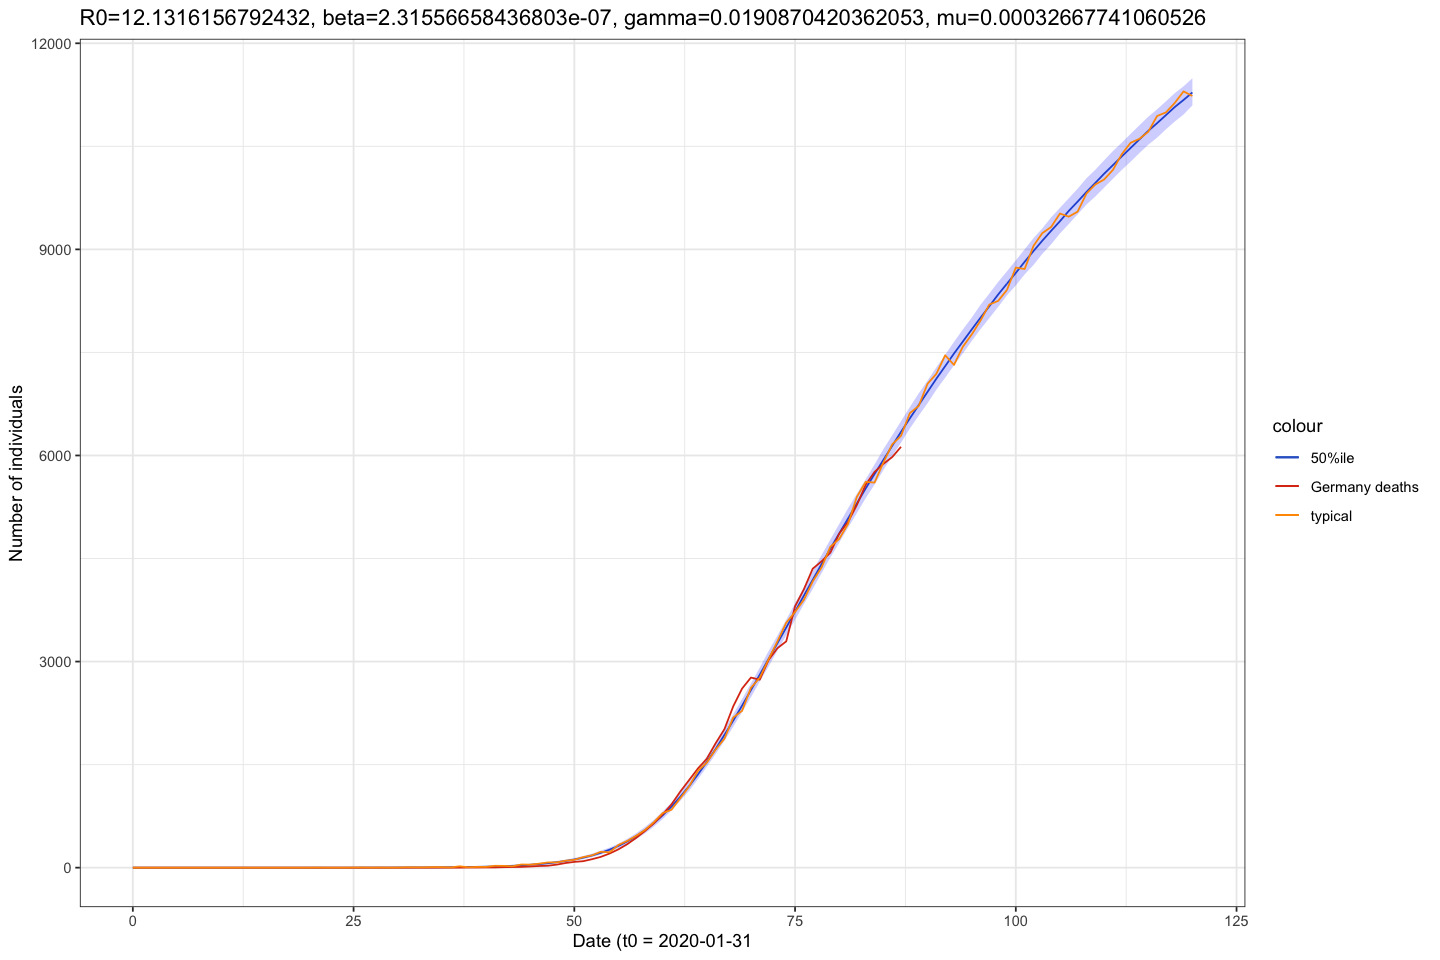

In [823]:
# run 2000 simulations of optimized parameters

raply(2000,rpois(n=length(pred$D),lambda=p.scale * pred$D)) -> simdat
aaply(simdat,2,quantile,probs=c(0.025,0.5,0.975)) -> quantiles

typ <- sample(nrow(simdat),1)

p <- ggplot(data=cbind(join(pred, mysite, by='t'),
                       quantiles,
                       typical=simdat[typ,]),
            mapping=aes(x=t))
p <- p + theme_bw() + scale_color_gdocs()
p <- p + geom_line(aes(y=`50%`, col='50%ile'))
p <- p + geom_ribbon(aes(ymin=`2.5%`,ymax=`97.5%`), fill='blue', alpha=0.2)
p <- p + geom_line(aes(y=death, col=paste0(mysite.name, ' deaths')))
p <- p + geom_line(aes(y=typical, col='typical'))
p <- p + labs(y="Deaths",x="t")
# p <- p + scale_x_continuous(limit=c(70,80))
# p <- p + scale_y_continuous(limit=c(1.2e4,1.7e4))
# p <- p + scale_y_continuous(trans='log10')
p <- p + ggtitle(paste0('R0=', R0, ', beta=', exp(opt[1]), ', gamma=', exp(opt[2]), ', mu=', exp(opt[3])))
p <- p + xlab(paste0('Date (t0 = ', t0)) + ylab('Number of individuals')
p

# Multiple sites for simultaneous parameter estimation

Here, we'll assess multiple local sites simultaneously while fixing disease specific variable ($\beta$, $\gamma$, $\mu$) across all settings. This model makes the assumption that mortality, infectious period, and infectivity are stable across cultural/geographic boundaries. While this is somewhat unrealistic, it may inform some underlying characteristics of SARS-CoV-2.

##### Dataset choice

- $\ge$ 5 sites
- Sites should be relatively isolated
- Death data must be reliable
- Prefer mature curve (past inflection point)
- Similar access to healthcare, population demographics, ?climate

Also note that Johns Hopkins data is based on state-reported deaths. On 2020-04-05, the Council of State and Territorial Epidemiologists Centers advised states to include both confirmed and probable deaths. This leads to discrete jumps in the data (~4000 deaths added to NYC in 1 day) that may complicate analysis of the death trajectory (see [NYTimes vs JHU data](https://github.com/spencerwoody/covid19-data-comparsion)).

We'll start by fitting to U.S. cities based on the NYTimes data

Cities
- Detroit
- Boston

Start at 10 deaths?


In [318]:
# clean up data
jhu.death <- read_csv('data/jhu/time_series_covid19_deaths_global.2020-04-24.csv.gz')
gdeath <- melt(select(jhu.death,
                      'subregion'="Province/State",
                      'region'='Country/Region',
                      matches('[0-9]*/[0-9]*/[0-9]*')),
               id=c('subregion', 'region'),
               variable.name='date', value.name='death')
gdeath$region <- factor(gdeath$region)
gdeath$date <- as.Date(gdeath$date, format='%m/%d/%y')

Parsed with column specification:
cols(
  .default = col_double(),
  `Province/State` = col_character(),
  `Country/Region` = col_character()
)

See spec(...) for full column specifications.



# Predictive accuracy

We'd like to assess the predictive utility of the model by running it on partial data and evaluating whether subsequent data agrees with the prediction.

- Poisson error model
- Maximize log-likelihood with simultaneous optimization of $\beta$, $\mu$, $\gamma$
- Generate predictions at $0 \le t \le u $

In [717]:
# to do

# To do

- [x] Multiple cities/locales
- [x] Assess sensitivity to $N$
    - Problematically sensitive to choice of $N$ on a countrywide-scale in Italy
    - Try assessing cities/counties instead of country data
- [ ] Use the Grand Princess cruise ship data
- [ ] Assess predictive power at different modeling endpoints
- [ ] Adjust for population demographic differences with age-scaled $\mu$
- [ ] Evaluate cases as a lower bound for infection prevalence
- [ ] Compare to preliminary serology reports
- [ ] Negative binomial model
- [ ] Use SEIR model

# References

1. https://kingaa.github.io/short-course/parest/parest.html
    - Methods are techniques derived heavily from this [excellent course](http://kingaa.github.io/short-course/) from Adam King at U Michigan